In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import warnings
from datetime import datetime, timedelta
from tqdm import tqdm
import traceback

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# TensorFlow/Keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Transformers
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, AutoModelForSequenceClassification, pipeline, AutoTokenizer

# Statsmodels & Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# XGBoost and LightGBM
from xgboost import XGBRegressor
import lightgbm as lgb

# SHAP
import shap

# NLTK and TextBlob
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import nltk

# Yahoo Finance
import yfinance as yf



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


# Project


#### Project Overview
This project predicts Bitcoin's next-day price percentage change by integrating sentiment analysis of X posts with historical price data, using deep learning models (LSTM and GRU). It fulfills the requirements of the MSc in IT for Business Data Analytics Capstone Project at the International Business School, The University of Buckingham.

#### Objectives
- Collect and preprocess X posts and cryptocurrency price data.\n",
- Perform sentiment analysis using a BERT-based model.\n",
- Conduct exploratory data analysis (EDA) to identify trends and correlations.\n",
- Implement and optimize LSTM and GRU models.\n",
- Evaluate model performance and provide business insights.\n",

#### Dependencies
Run the following cell to import all required libraries. Ensure `requirements.txt` is installed as per the README

# Dataset Cleaning Tweets


#### Data Collection

We collect X posts related to Bitcoin from Feb 2021 to Jan 2023, containing 224,821 tweets. Only the `date` and `text` columns are retained for analysis.

**Note**: Update the file path below to your local copy of `Bitcoin_tweets.csv`.


In [89]:
# Define columns you want to keep
columns_to_keep = ['date', 'text']

# Create an empty CSV to save the cleaned version
output_file = 'bitcoin_tweets_date_text.csv'
first_chunk = True

for chunk in pd.read_csv('/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets.csv', chunksize=100000, engine='python'):  
    chunk = chunk[columns_to_keep]
    chunk.to_csv(output_file, mode='a', index=False, header=first_chunk)
    first_chunk = False

In [90]:
df_raw = pd.read_csv("/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/bitcoin_tweets_date_text.csv")

In [91]:
df_raw.head()

,date,text
0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...
1,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""..."
2,2021-02-10 23:54:48,"Guys evening, I have read this article about B..."
3,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...
4,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...


#### Tweet Cleaning

We clean the tweet data by:
- Sampling 5% of the data to manage computational constraints.
- Removing noise (hashtags, URLs, mentions) using vectorized operations for efficiency.

In [6]:
# clean df 
df_raw = df_raw.sort_values(by = 'date')
dd = df_raw.sample(frac= 0.05, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
tweets_clean_file = '/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets_clean.csv'
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

  6%|▋         | 29592/469309 [10:37<2:37:46, 46.45it/s]  


KeyboardInterrupt: 

In [92]:
df_clean = pd.read_csv('/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets_clean.csv')

In [93]:
#Displaying the first few rows of the data
df_clean.head()

,index,date,text
0,3885516,2022-07-15 13:47:46,Aeron (ARNX) went up 11.6 percent in the last ...
1,984434,2021-08-16 05:15:11,Bitcoin looking bullish👍\n\nA Golden Cross on ...
2,207647,2021-06-21 21:42:06,I have made 23X gain from doge. Now how many X...
3,2529662,2022-03-16 16:05:00,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...
4,552292,2021-07-18 14:28:49,This is definitely going to be HUGE! as the t...


In [94]:
df = df_clean.copy()
df = df[['text']] 
df.columns = ['tweets']
df.head()

,tweets
0,Aeron (ARNX) went up 11.6 percent in the last ...
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...
2,I have made 23X gain from doge. Now how many X...
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...
4,This is definitely going to be HUGE! as the t...


In [95]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [96]:
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [97]:
# Clean missing tweets
df['tweets'] = df['tweets'].fillna("")

# Clean tweets
df['cleaned_tweets'] = df['tweets'].apply(cleaning)

# Set date properly
df['date'] = df_clean['date']   # WARNING: make sure df_clean has no weird data
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

# Drop bad rows where date_clean is NaT
df = df.dropna(subset=['date_clean'])

# Drop old 'date' column
df.drop(columns='date', inplace=True)

# Show result
df.head()


,tweets,cleaned_tweets,date_clean
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18


In [ ]:
# Creating a copy to avoid modifying original
crypto_scaled_df = crypto_ml_df.copy()


We can now see the tweets and data cleaned which are now ready for the sentiment analysis.

### EDA-Tweets

In [98]:
# Create daily tweet aggregation with cleaned data
daily_tweets = df.groupby('date_clean').size().reset_index(name='tweet_count')

# Print daily tweet statistics
print("Daily tweet statistics:")
print(daily_tweets['tweet_count'].describe())

Daily tweet statistics:
count     222.000000
mean     1056.211712
std       758.638716
min         6.000000
25%       322.750000
50%       946.000000
75%      1595.500000
max      3492.000000
Name: tweet_count, dtype: float64


In [99]:
print(df['date_clean'].min())
print(df['date_clean'].max())


2021-02-05
2023-01-09


# Data Bitcoin Prices

We get the bitcoin prices from the dates 2021-02-05 till 2023-01-09

In [100]:
# Fetch historical Bitcoin prices
def get_btc_prices(start_date='2021-02-05', end_date='2023-01-09'):
    btc = yf.Ticker("BTC-USD")
    df = btc.history(start=start_date, end=end_date)
    return df[['Close', 'Volume']].rename(columns={'Close': 'price'})

# Sentiment Analysis

CryptoBERT is a pre-trained NLP model to analyse the language and sentiments of cryptocurrency-related social media posts and messages. It was built by further training the vinai's bertweet-base language model on the cryptocurrency domain, using a corpus of over 3.2M unique cryptocurrency-related social media posts.

The model was trained on the following labels: "Bearish" : 0, "Neutral": 1, "Bullish": 2



loads the model and tokenizer using the AutoTokenizer and AutoModelForSequenceClassification classes.

In [101]:
tokenizer = AutoTokenizer.from_pretrained('ElKulako/cryptobert')
model = AutoModelForSequenceClassification.from_pretrained('ElKulako/cryptobert')
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def batch_sentiment(texts, batch_size=32):
    sentiments = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        results = sentiment_pipeline(batch)
        sentiments.extend(results)
    return sentiments

Now we apply the sentiment analysis

In [102]:
# Apply sentiment analysis
sentiments = batch_sentiment(df['cleaned_tweets'].tolist())
df['sentiment'] = [s['label'] for s in sentiments]
df['sentiment_score'] = [s['score'] for s in sentiments]

In [105]:
# Ensure 'date_clean' is in datetime format
df['date_clean'] = pd.to_datetime(df['date_clean'])

# Sort the DataFrame by date
df = df.sort_values(by='date_clean').reset_index(drop=True)

# Optional: Preview the first few rows
df.head()


,tweets,cleaned_tweets,date_clean,sentiment,sentiment_score
0,"Bitcoin BTC current price (GBP): £27,618\nLike...",Bitcoin BTC current price GBP Like update tip ...,2021-02-05,Neutral,0.859732
1,Tune in to : The Bitcoin Revolution Isn't Comi...,Tune The Bitcoin Revolution Isn Coming It Alre...,2021-02-05,Bullish,0.576274
2,Bitcoin BTC Crypto \nThe last few months of BT...,Bitcoin BTC Crypto The last month BTC bootcamp...,2021-02-05,Bullish,0.546551
3,IF YOUR IN CRYPTO BE CAREFUL!!!\nTHIS IS A SCA...,IF YOUR IN CRYPTO BE CAREFUL THIS IS A SCAM Cr...,2021-02-05,Neutral,0.701728
4,This is not just a billionaire! \n\nHe is the ...,This billionaire He richest human EARTH Some p...,2021-02-05,Bullish,0.529897


We now have the sentiment and the sentiment score

Text(0.5, 1.0, 'Sentiment Score by Category')

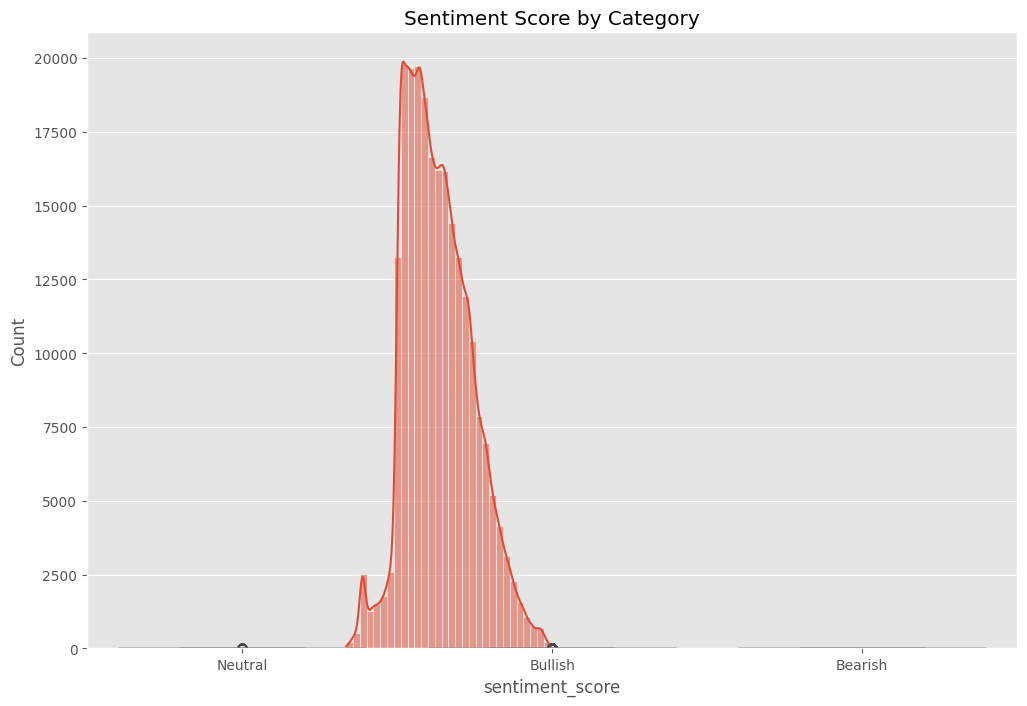

In [104]:
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title('Sentiment Score Distribution')

sns.boxplot(x='sentiment', y='sentiment_score', data=df)
plt.title('Sentiment Score by Category')


<Axes: title={'center': 'Daily Sentiment Counts'}, xlabel='date_clean'>

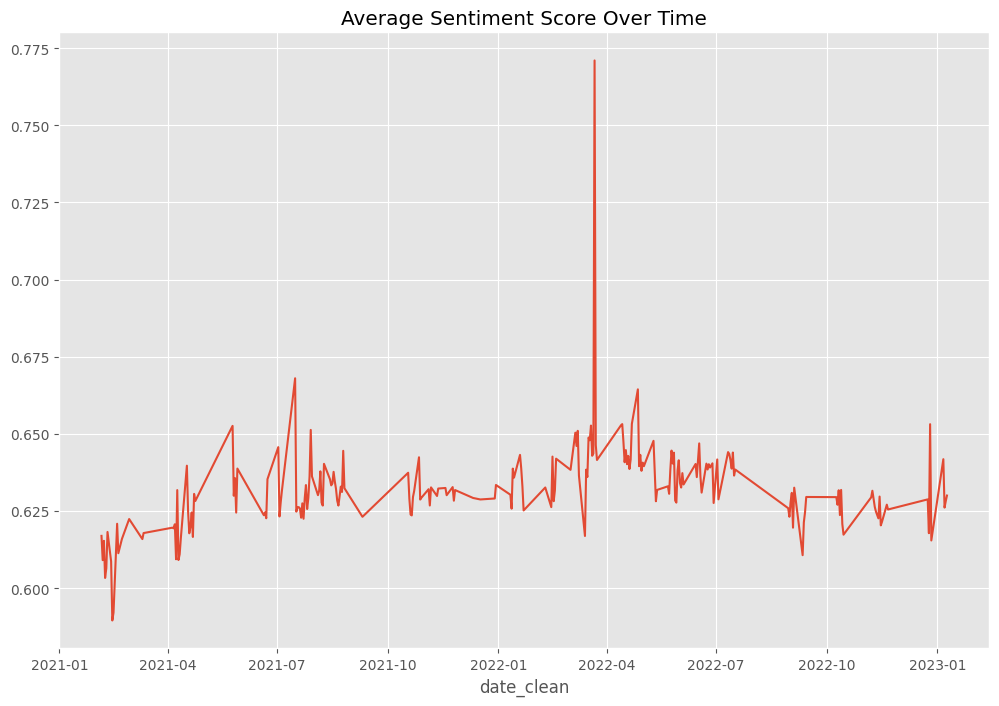

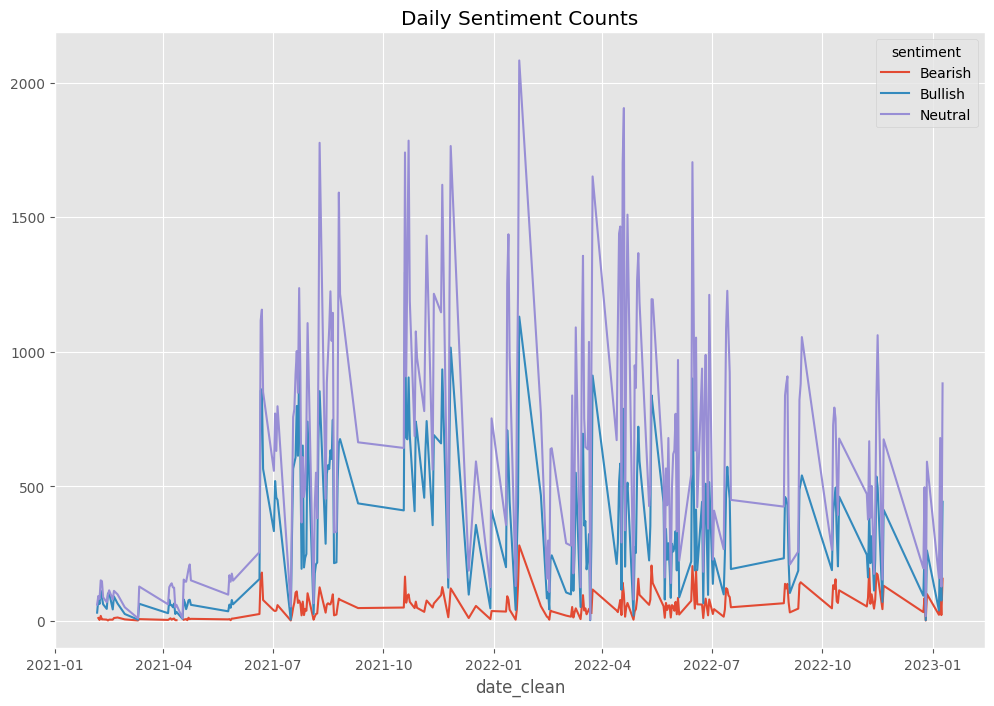

In [107]:
daily_sentiment = df.groupby(df['date_clean'].dt.date)['sentiment_score'].mean()
daily_sentiment.plot(title='Average Sentiment Score Over Time')

sentiment_counts = df.groupby([df['date_clean'].dt.date, 'sentiment']).size().unstack()
sentiment_counts.plot(title='Daily Sentiment Counts')


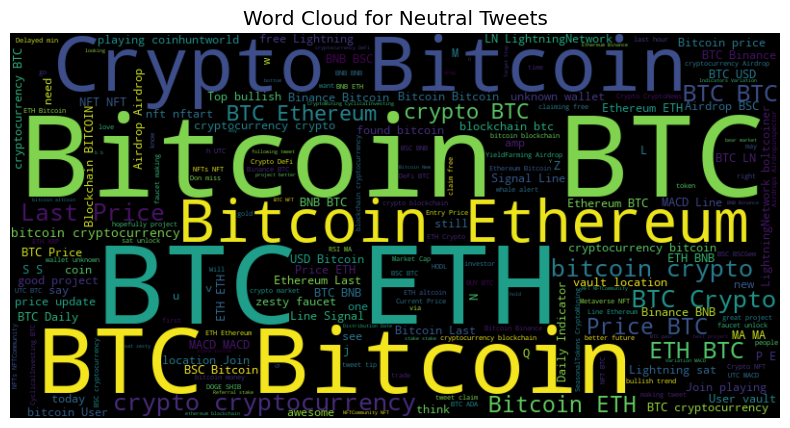

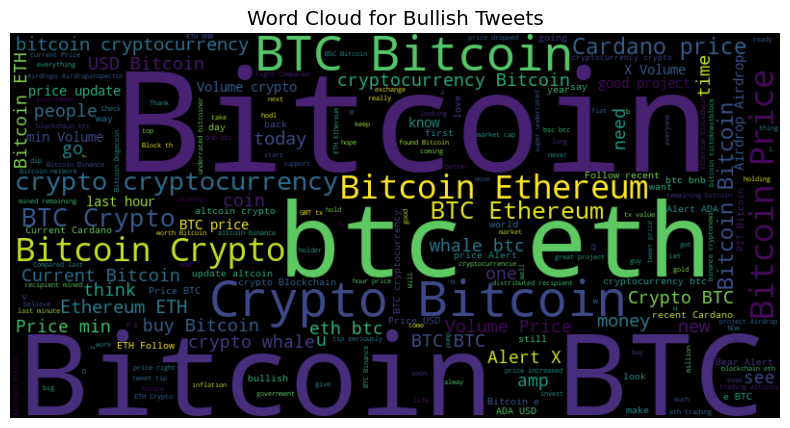

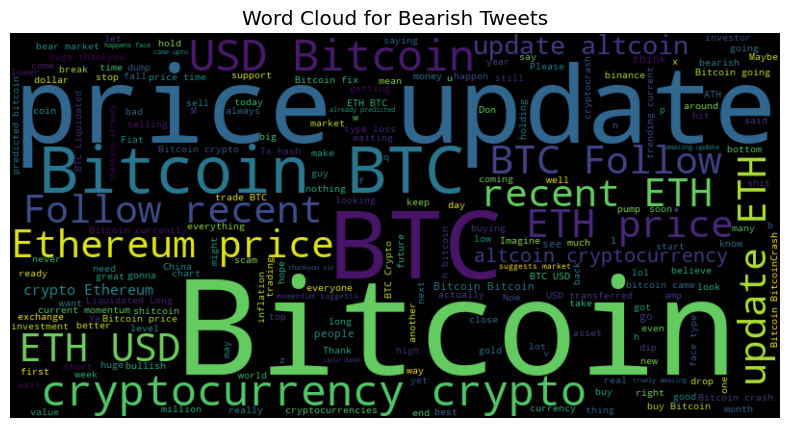

In [108]:
from wordcloud import WordCloud

for sentiment in df['sentiment'].unique():
    text = " ".join(df[df['sentiment'] == sentiment]['cleaned_tweets'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Tweets')
    plt.axis('off')
    plt.show()


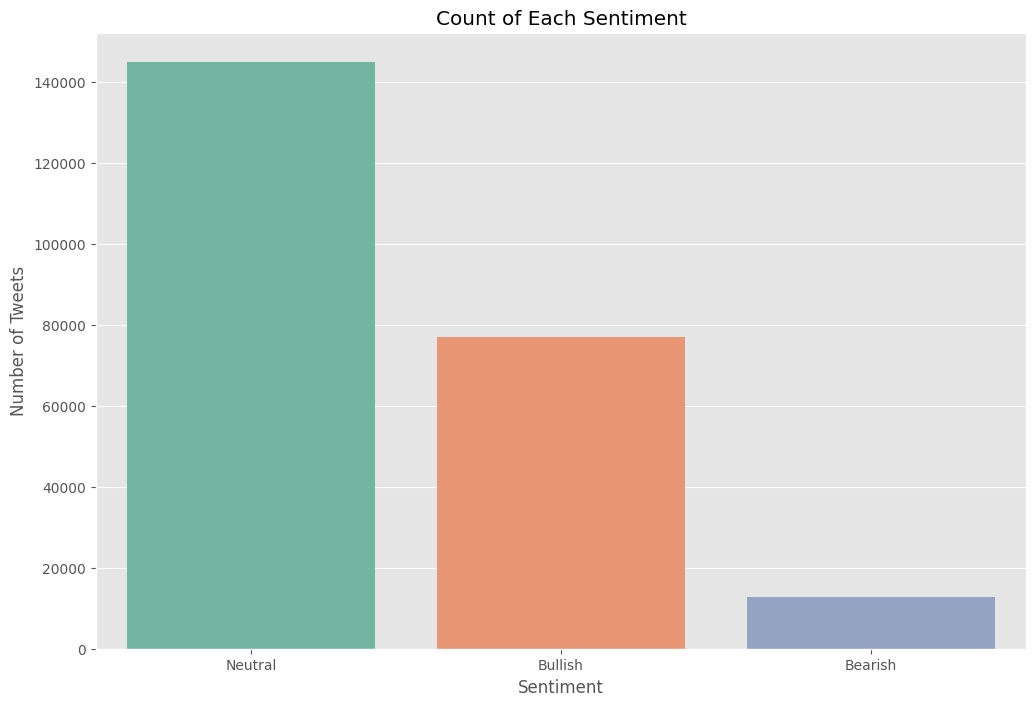

In [116]:
# Plot count of each sentiment
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title('Count of Each Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

## Data Integration

In [112]:
print(df.columns)

Index(['tweets', 'cleaned_tweets', 'date_clean', 'sentiment',
       'sentiment_score', 'tweet_length', 'word_count', 'hour', 'weekday'],
      dtype='object')


In [115]:
# Updated function to get multiple crypto prices
def get_crypto_prices(tickers=['BTC-USD'], start_date='2020-01-01', end_date='2023-12-31'):
    data = {}
    for ticker in tickers:
        crypto = yf.Ticker(ticker)
        hist = crypto.history(start=start_date, end=end_date)
        if not hist.empty:
            sym = ticker.split('-')[0]
            # price series
            data[sym] = hist['Close']
            # volume series
            data[f'{sym}_volume'] = hist['Volume']
    return pd.DataFrame(data)

# Get prices for all cryptos
top_cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'SOL-USD', 'XRP-USD']
price_df = get_crypto_prices(top_cryptos)
price_df.index = price_df.index.tz_localize(None).strftime('%Y-%m-%d')
merged_df = pd.merge(df,
                     price_df,
                     left_on='date_clean',
                     right_index=True,
                     how='inner')

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [20]:
print(merged_df.columns)

Index(['tweets', 'cleaned_tweets', 'date_clean', 'sentiment',
       'sentiment_score', 'BTC', 'BTC_volume', 'ETH', 'ETH_volume', 'BNB',
       'BNB_volume', 'ADA', 'ADA_volume', 'SOL', 'SOL_volume', 'XRP',
       'XRP_volume', 'price_change_btc'],
      dtype='object')


In [43]:
merged_df.head()

,tweets,cleaned_tweets,date_clean,sentiment,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume,price_change_btc
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,Neutral,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333,1.207898
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,Neutral,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221,-0.311443
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,Bullish,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475,0.298871
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,Neutral,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473,-0.227181
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,Bullish,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722,-0.067341


### Trading Strategy

In [22]:
def trading_strategy(df, threshold=0.5):
    """Generate trading signals based on sentiment thresholds"""
    df['signal'] = 'HOLD'
    df.loc[df['sentiment_score'] > threshold, 'signal'] = 'BUY'  
    df.loc[df['sentiment_score'] < -threshold, 'signal'] = 'SELL'  
    return df
# Apply strategy
strategy_df = trading_strategy(merged_df.copy())

In [42]:
strategy_df.head()

,tweets,cleaned_tweets,date_clean,sentiment,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume,price_change_btc,signal
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,Neutral,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333,1.207898,BUY
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,Neutral,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221,-0.311443,BUY
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,Bullish,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475,0.298871,BUY
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,Neutral,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473,-0.227181,BUY
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,Bullish,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722,-0.067341,BUY


In [2]:
ml_df = merged_df.copy()

NameError: name 'merged_df' is not defined

In [98]:
ml_df = ml_df.drop(columns=['tweets', 'cleaned_tweets', 'price_change_btc', 'sentiment'])

ml_df.head()

,date_clean,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
0,2022-07-15,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333
1,2021-08-16,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221
2,2021-06-21,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475
3,2022-03-16,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473
4,2021-07-18,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722


In [99]:
crypto_columns = crypto_columns = [
    'BTC', 'BTC_volume',
    'ETH', 'ETH_volume',
    'BNB', 'BNB_volume',
    'ADA', 'ADA_volume',
    'SOL', 'SOL_volume',
    'XRP', 'XRP_volume'
]
scaler = MinMaxScaler()
ml_df[crypto_columns] = scaler.fit_transform(ml_df[crypto_columns])

### Exploratary Data Analysis

In [100]:
ml_df.info()
ml_df.describe()
ml_df.isnull().sum()
ml_df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 234478 entries, 0 to 234653
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date_clean       234478 non-null  object 
 1   sentiment_score  234478 non-null  float64
 2   BTC              234478 non-null  float64
 3   BTC_volume       234478 non-null  float64
 4   ETH              234478 non-null  float64
 5   ETH_volume       234478 non-null  float64
 6   BNB              234478 non-null  float64
 7   BNB_volume       234478 non-null  float64
 8   ADA              234478 non-null  float64
 9   ADA_volume       234478 non-null  float64
 10  SOL              234478 non-null  float64
 11  SOL_volume       234478 non-null  float64
 12  XRP              234478 non-null  float64
 13  XRP_volume       234478 non-null  float64
dtypes: float64(13), object(1)
memory usage: 26.8+ MB


np.int64(23564)

In [102]:
ml_df['date_clean'] = pd.to_datetime(ml_df['date_clean'])
ml_df = ml_df.sort_values('date_clean')

In [103]:
ml_df.head()

,date_clean,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
190775,2021-02-05,0.539968,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
166331,2021-02-05,0.638531,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
101285,2021-02-05,0.639123,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
101288,2021-02-05,0.691379,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
45286,2021-02-05,0.804063,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359


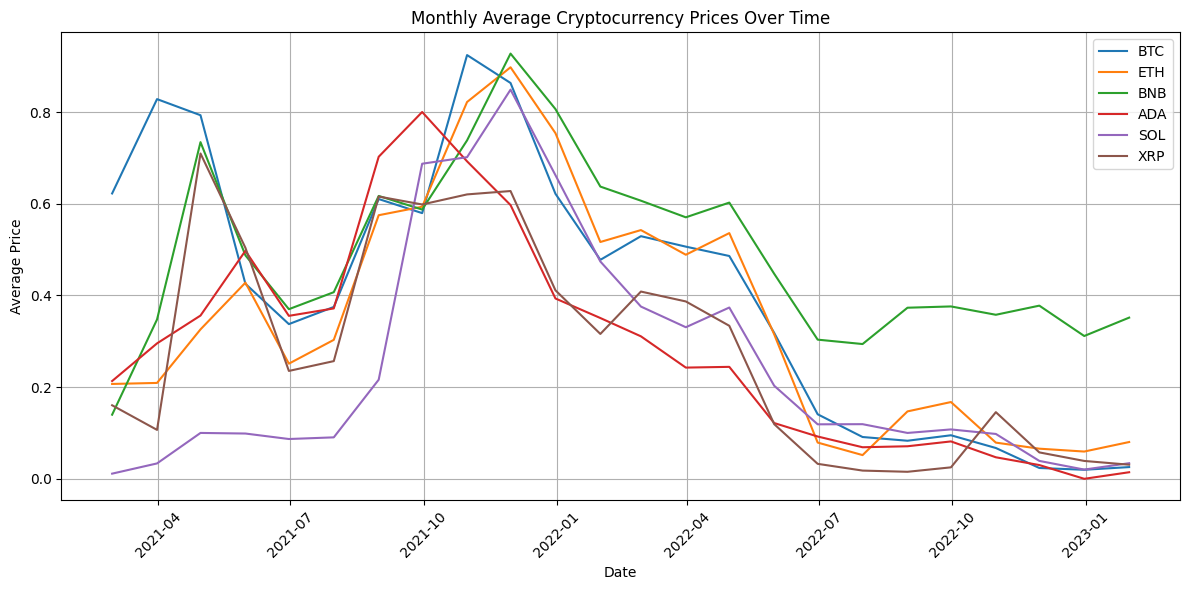

In [106]:
# Aggregate by month (mean)
# Set date as index for resampling
ml_df_indexed = ml_df.set_index('date_clean')

# Aggregate by month (mean)
crypto_columns = ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']
monthly_avg = ml_df_indexed[crypto_columns].resample('M').mean()

# Plot
plt.figure(figsize=(12, 6))
for coin in crypto_columns:
    plt.plot(monthly_avg.index, monthly_avg[coin], label=coin)

plt.legend()
plt.title('Monthly Average Cryptocurrency Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

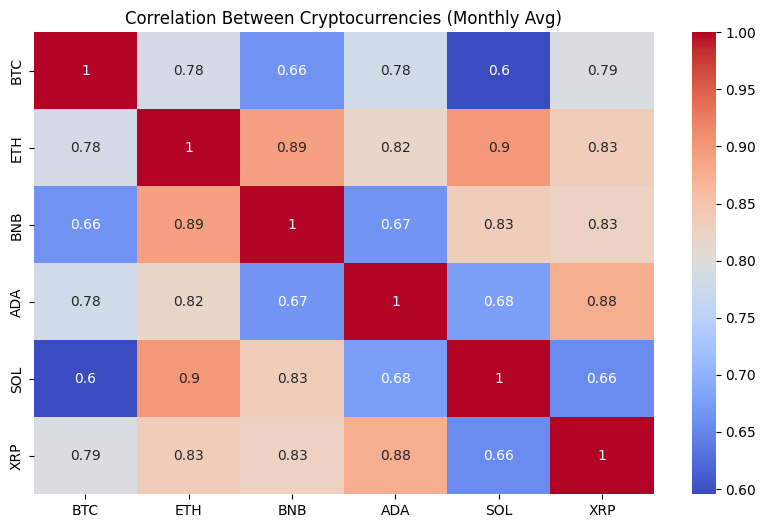

In [108]:
# Set date as index for resampling
ml_df_indexed = ml_df.set_index('date_clean')

# Recalculate monthly data (mean)
crypto_columns = ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']
monthly_df = ml_df_indexed[crypto_columns].resample('M').mean()

# Plot heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Cryptocurrencies (Monthly Avg)')
plt.show()

#### Feature Importance

            Feature    Importance
5               XRP  6.497507e-01
1               ETH  3.052952e-01
4               SOL  1.867854e-02
3               ADA  1.594038e-02
8        ADA_volume  3.223178e-03
10       XRP_volume  2.968496e-03
2               BNB  2.261812e-03
6        ETH_volume  7.774896e-04
9        SOL_volume  5.765747e-04
7        BNB_volume  5.276185e-04
0   sentiment_score  7.097205e-14


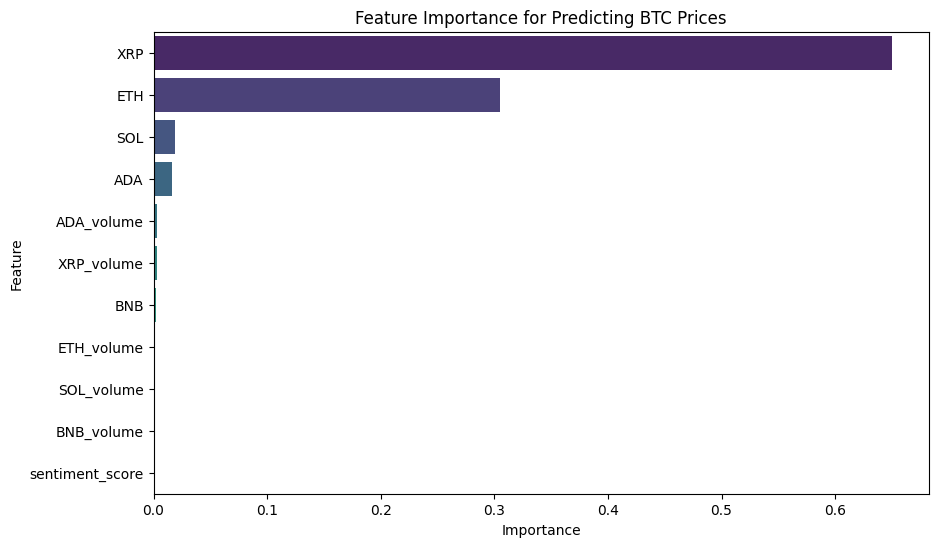

In [111]:
# Define the features (independent variables)
features = ml_df[['sentiment_score', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP', 'ETH_volume', 'BNB_volume', 'ADA_volume', 'SOL_volume', 'XRP_volume']]

# Define the target (dependent variable), e.g., BTC prices
target = ml_df['BTC']

# Train a RandomForest model using the features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features, target)

# Extract feature importances and create a DataFrame to visualize
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

# Sort the features by importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importances
print(importance_df)

# Visualize the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Predicting BTC Prices')
plt.show()

In [112]:
ml_df.head()

,date_clean,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
190775,2021-02-05,0.539968,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
166331,2021-02-05,0.638531,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
101285,2021-02-05,0.639123,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
101288,2021-02-05,0.691379,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
45286,2021-02-05,0.804063,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359


In [113]:
output_path = "ml_df-1.csv"
ml_df.to_csv(output_path, index=False)
print(f"Dataset successfully saved to {output_path}")

Dataset successfully saved to ml_df-1.csv


## Crypto Model

In [2]:
# Define the crypto tickers and their labels
crypto_tickers = {
    'BTC-USD': 'BTC',
    'ETH-USD': 'ETH',
    'BNB-USD': 'BNB',
    'ADA-USD': 'ADA',
    'SOL-USD': 'SOL',
    'XRP-USD': 'XRP'
}

# Define the time range
start_date = '2020-04-10'
end_date = '2025-04-30'

In [3]:
# Download data
crypto_data = {}
for ticker in crypto_tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Close', 'Volume']].rename(columns={'Close': crypto_tickers[ticker], 'Volume': f"{crypto_tickers[ticker]}_volume"})
    crypto_data[crypto_tickers[ticker]] = data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Combine all crypto data on date
crypto_ml_df = pd.concat(crypto_data.values(), axis=1, join='inner')
crypto_ml_df.reset_index(inplace=True)
crypto_ml_df.head()

Price,Date,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
Ticker,,BTC-USD,BTC-USD,ETH-USD,ETH-USD,BNB-USD,BNB-USD,ADA-USD,ADA-USD,SOL-USD,SOL-USD,XRP-USD,XRP-USD
0,2020-04-10,6865.493164,43622840992,158.412445,17980944616,13.737724,394331907,0.033215,95977717,0.951054,87364276,0.187464,2105282079
1,2020-04-11,6859.083008,31222085946,158.216019,13555089447,13.804288,364313702,0.033354,75648111,0.776819,43862444,0.188063,1847482831
2,2020-04-12,6971.091797,35759567632,161.142426,15123721386,14.375111,414752932,0.033806,73751090,0.882507,38736897,0.190135,2087857417
3,2020-04-13,6845.037598,38619308647,156.279556,16465282133,15.034427,459561236,0.033107,84000834,0.777832,18211285,0.187732,2253497429
4,2020-04-14,6842.427734,34110434052,157.596390,14723156630,15.525076,515331620,0.032974,74633336,0.661925,16747614,0.185335,1889687587


### Crypto EDA

In [5]:
# Creating a copy to avoid modifying original
crypto_scaled_df = crypto_ml_df.copy()


In [6]:
# Select only numeric columns to scale (excluding 'Date')
numeric_cols = crypto_scaled_df.select_dtypes(include='number').columns

In [7]:
# Initialize and apply scaler
scaler = MinMaxScaler()
crypto_scaled_df[numeric_cols] = scaler.fit_transform(crypto_scaled_df[numeric_cols])

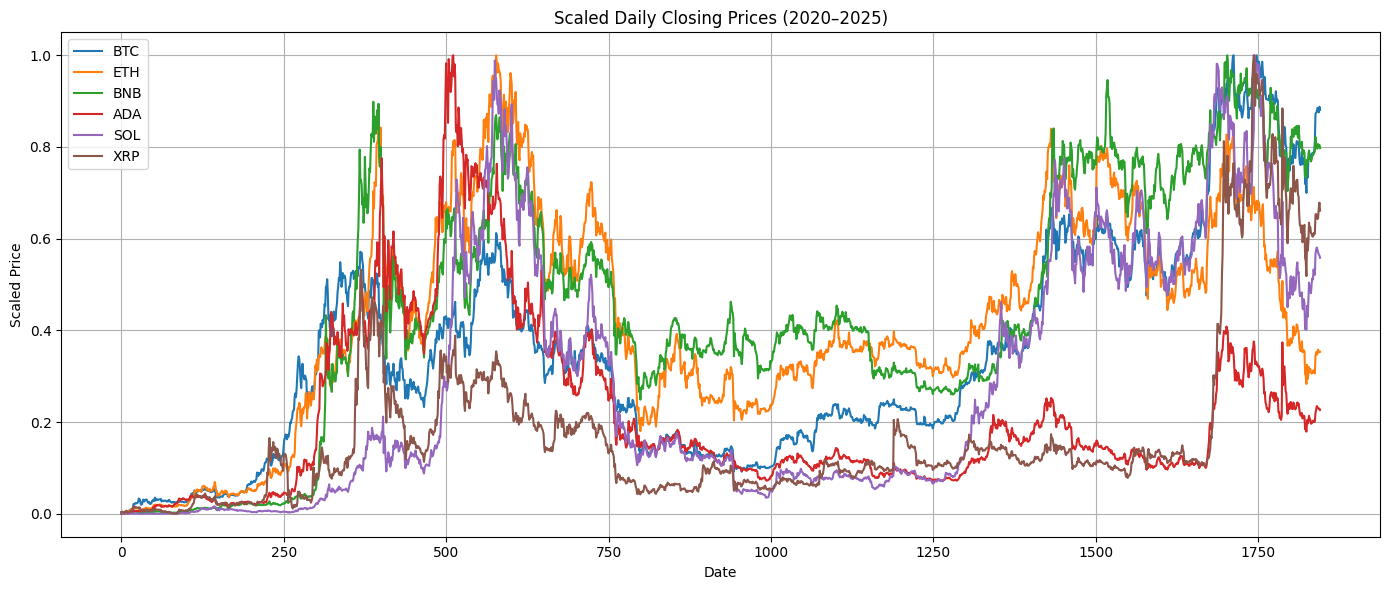

In [8]:
plt.figure(figsize=(14, 6))
for coin in ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']:
    plt.plot(crypto_scaled_df.index, crypto_scaled_df[coin], label=coin)

plt.title('Scaled Daily Closing Prices (2020–2025)')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

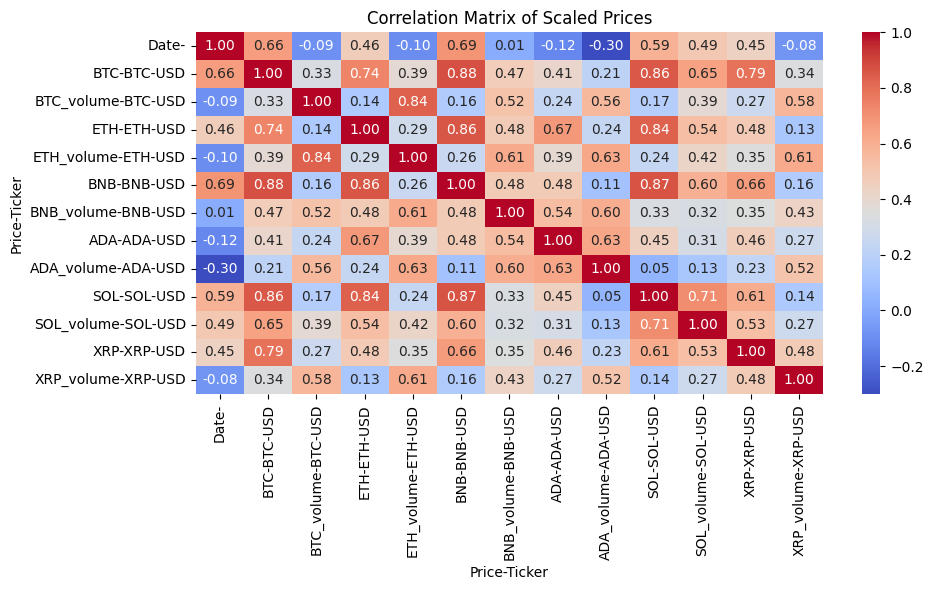

In [9]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(crypto_scaled_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Scaled Prices')
plt.tight_layout()
plt.show()


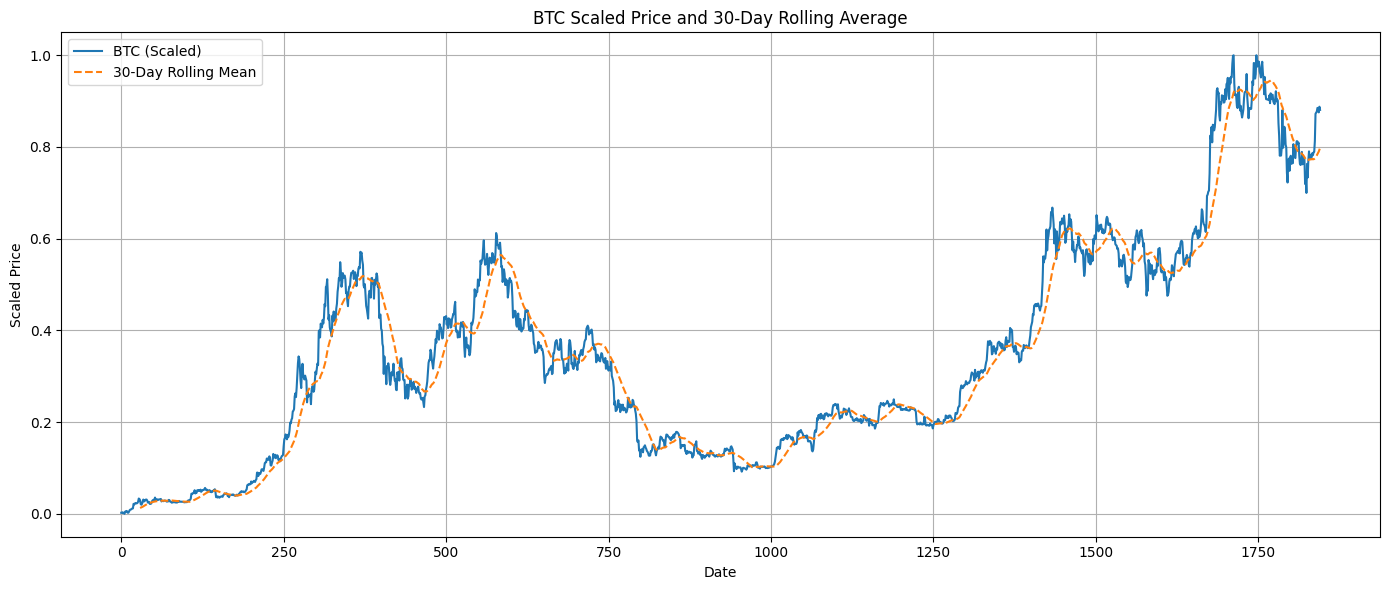

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(crypto_scaled_df.index, crypto_scaled_df['BTC'], label='BTC (Scaled)')
plt.plot(crypto_scaled_df.index, crypto_scaled_df['BTC'].rolling(window=30).mean(), 
         label='30-Day Rolling Mean', linestyle='--')

plt.title('BTC Scaled Price and 30-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


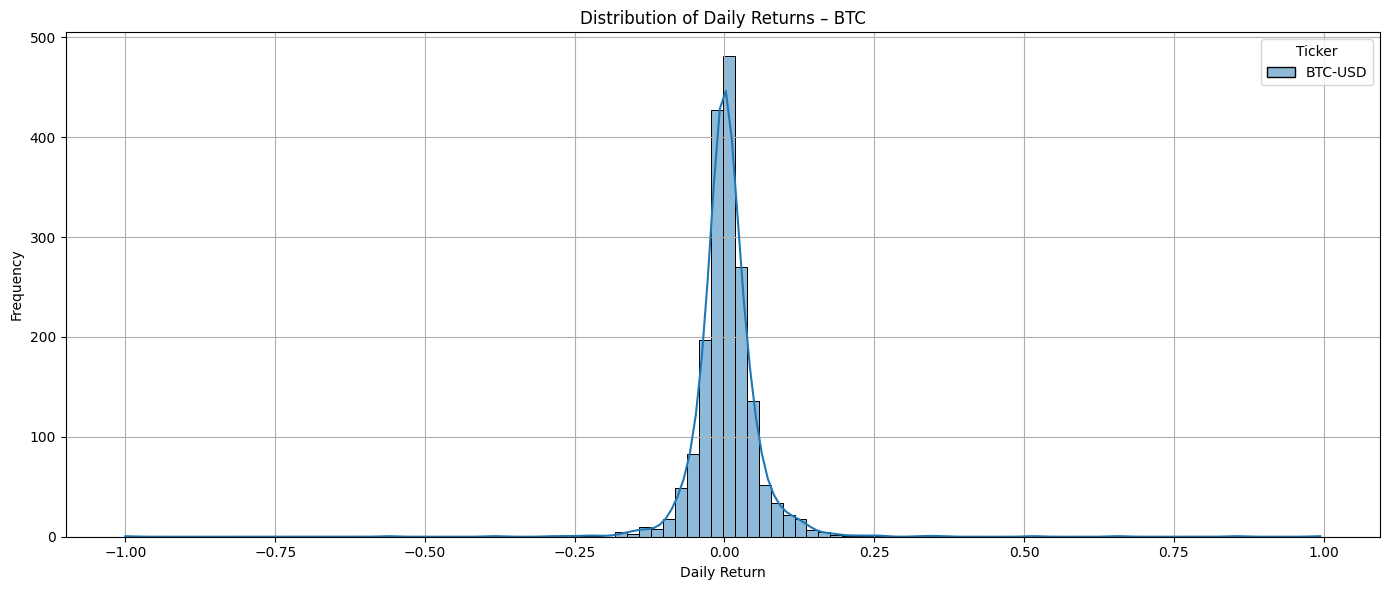

In [11]:
# Reset index so 'date' becomes a column temporarily
crypto_temp = crypto_scaled_df.reset_index()

# Compute daily returns (excluding 'date' column)
crypto_returns = crypto_temp[['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']].pct_change().dropna()

# Plot distribution for BTC
plt.figure(figsize=(14, 6))
sns.histplot(crypto_returns['BTC'], bins=100, kde=True, color='skyblue')
plt.title('Distribution of Daily Returns – BTC')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

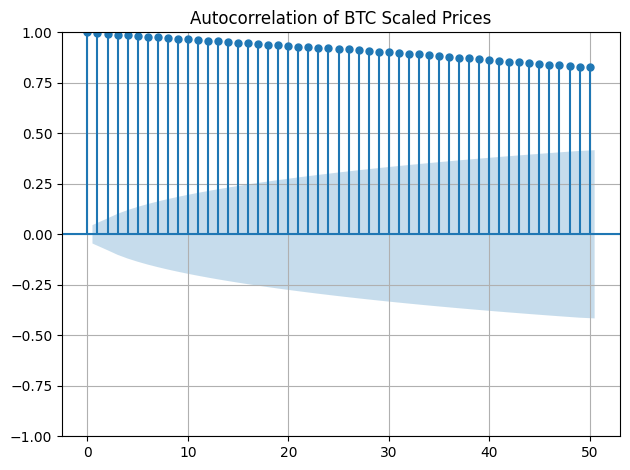

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 5))
plot_acf(crypto_scaled_df['BTC'].dropna(), lags=50)
plt.title('Autocorrelation of BTC Scaled Prices')
plt.grid(True)
plt.tight_layout()
plt.show()


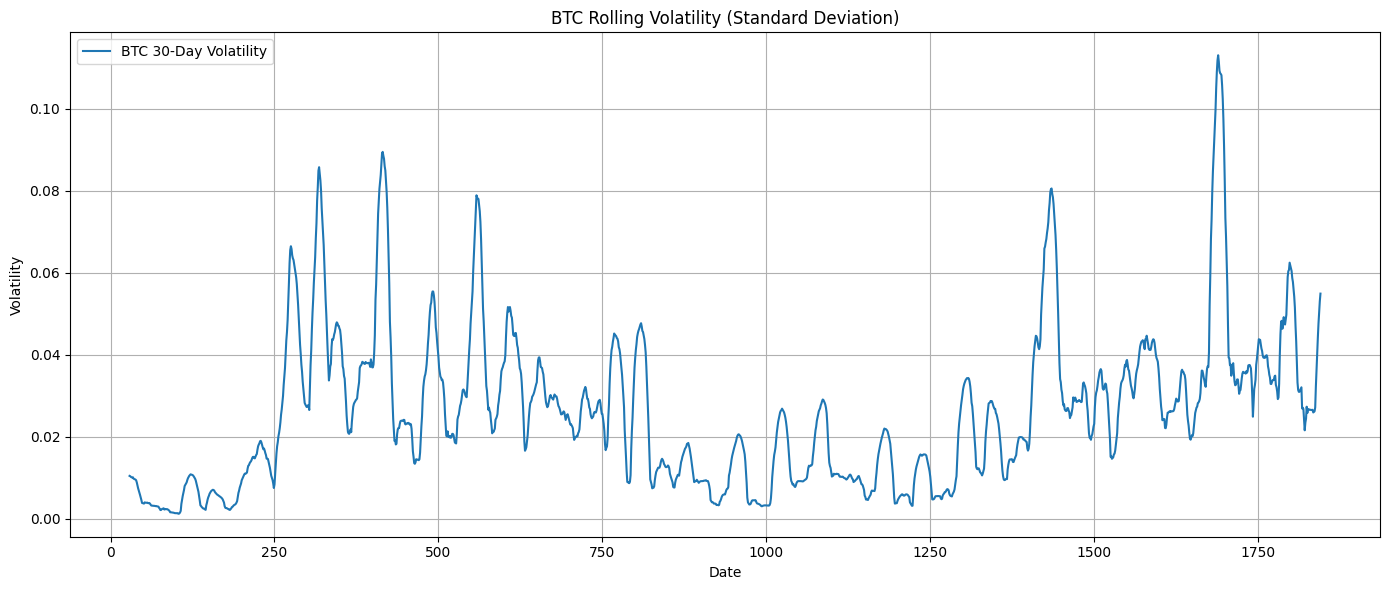

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(crypto_scaled_df['BTC'].rolling(window=30).std(), label='BTC 30-Day Volatility')
plt.title('BTC Rolling Volatility (Standard Deviation)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Model Training

#### Feature Engineering

In [14]:
# Make plots larger and more readable
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# First, let's check what our dataset looks like
print("Dataset shape:", crypto_ml_df.shape)
print("\nFirst 5 rows:")
display(crypto_ml_df.head())

# Check for missing values
print("\nMissing values:")
print(crypto_ml_df.isnull().sum())

# Convert Date column to datetime format if not already
if not pd.api.types.is_datetime64_any_dtype(crypto_ml_df['Date']):
    crypto_ml_df['Date'] = pd.to_datetime(crypto_ml_df['Date'])

# Set Date as index
crypto_ml_df.set_index('Date', inplace=True)

# Sort by date to ensure chronological order
crypto_ml_df.sort_index(inplace=True)

# Display basic statistics
print("\nBasic statistics:")
display(crypto_ml_df.describe())


Dataset shape: (1846, 13)

First 5 rows:


Price,Date,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
Ticker,,BTC-USD,BTC-USD,ETH-USD,ETH-USD,BNB-USD,BNB-USD,ADA-USD,ADA-USD,SOL-USD,SOL-USD,XRP-USD,XRP-USD
0,2020-04-10,6865.493164,43622840992,158.412445,17980944616,13.737724,394331907,0.033215,95977717,0.951054,87364276,0.187464,2105282079
1,2020-04-11,6859.083008,31222085946,158.216019,13555089447,13.804288,364313702,0.033354,75648111,0.776819,43862444,0.188063,1847482831
2,2020-04-12,6971.091797,35759567632,161.142426,15123721386,14.375111,414752932,0.033806,73751090,0.882507,38736897,0.190135,2087857417
3,2020-04-13,6845.037598,38619308647,156.279556,16465282133,15.034427,459561236,0.033107,84000834,0.777832,18211285,0.187732,2253497429
4,2020-04-14,6842.427734,34110434052,157.596390,14723156630,15.525076,515331620,0.032974,74633336,0.661925,16747614,0.185335,1889687587



Missing values:
Price       Ticker 
Date                   0
BTC         BTC-USD    0
BTC_volume  BTC-USD    0
ETH         ETH-USD    0
ETH_volume  ETH-USD    0
BNB         BNB-USD    0
BNB_volume  BNB-USD    0
ADA         ADA-USD    0
ADA_volume  ADA-USD    0
SOL         SOL-USD    0
SOL_volume  SOL-USD    0
XRP         XRP-USD    0
XRP_volume  XRP-USD    0
dtype: int64

Basic statistics:


Price,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
Ticker,BTC-USD,BTC-USD,ETH-USD,ETH-USD,BNB-USD,BNB-USD,ADA-USD,ADA-USD,SOL-USD,SOL-USD,XRP-USD,XRP-USD
count,1846.000000,1.846000e+03,1846.000000,1.846000e+03,1846.000000,1.846000e+03,1846.000000,1.846000e+03,1846.000000,1.846000e+03,1846.000000,1.846000e+03
mean,41409.036062,3.356761e+10,2108.780745,1.709505e+10,343.314414,1.511664e+09,0.662946,1.400200e+09,74.935236,1.790551e+09,0.717463,3.368577e+09
std,23948.192080,2.024404e+10,1073.111682,1.091745e+10,197.773702,1.374472e+09,0.560069,2.030534e+09,70.881991,2.277911e+09,0.581058,4.538622e+09
min,6642.109863,5.331173e+09,153.286896,2.081626e+09,13.737724,1.365992e+08,0.031863,5.825736e+07,0.515273,6.520200e+05,0.175870,2.253910e+08
25%,22632.334961,2.043979e+10,1516.558167,9.640550e+09,237.622849,5.309764e+08,0.314543,3.022042e+08,19.182549,2.783352e+08,0.390422,1.094784e+09
50%,37324.607422,2.963824e+10,1937.230713,1.488192e+10,313.467438,1.302818e+09,0.451191,6.364651e+08,38.678888,1.146799e+09,0.529640,1.773782e+09
75%,58192.470703,4.075462e+10,2961.470825,2.116080e+10,529.586929,1.953729e+09,0.923297,1.535035e+09,138.468311,2.585399e+09,0.759323,3.457406e+09
max,106146.265625,3.509679e+11,4812.087402,9.245355e+10,750.272644,1.798295e+10,2.968239,1.914198e+10,261.869751,3.317296e+10,3.298635,5.172338e+10


In [15]:
# Create a new dataframe to work with, focusing on BTC
btc_df = crypto_ml_df[['BTC', 'BTC_volume']].copy()

# Feature 1: Add lag features (previous days' prices)
for i in range(1, 31):
    btc_df[f'BTC_lag_{i}'] = btc_df['BTC'].shift(i)

In [16]:
# Feature 2: Rolling statistics
btc_df['rolling_mean_7d'] = btc_df['BTC'].rolling(window=7).mean()
btc_df['rolling_mean_30d'] = btc_df['BTC'].rolling(window=30).mean()
btc_df['rolling_std_7d'] = btc_df['BTC'].rolling(window=7).std()
btc_df['rolling_std_30d'] = btc_df['BTC'].rolling(window=30).std()


In [17]:
# Feature 3: Technical indicators
# Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

btc_df['RSI_14'] = calculate_rsi(btc_df['BTC'], 14)

In [18]:
# Moving Average Convergence Divergence (MACD)
btc_df['EMA_12'] = btc_df['BTC'].ewm(span=12, adjust=False).mean()
btc_df['EMA_26'] = btc_df['BTC'].ewm(span=26, adjust=False).mean()
btc_df['MACD'] = btc_df['EMA_12'] - btc_df['EMA_26']
btc_df['MACD_signal'] = btc_df['MACD'].ewm(span=9, adjust=False).mean()

In [19]:
# Feature 4: Calendar features
btc_df['day_of_week'] = btc_df.index.dayofweek
btc_df['month'] = btc_df.index.month

In [20]:
# Feature 5: Add other crypto prices as features
crypto_list = ['ETH', 'BNB', 'ADA', 'SOL', 'XRP']

# Just add all the cryptos directly without checking correlation
for crypto in crypto_list:
    try:
        if crypto in crypto_ml_df.columns:
            btc_df[crypto] = crypto_ml_df[crypto]
            print(f"Added {crypto} as a feature")
    except Exception as e:
        print(f"Error adding {crypto}: {e}")

Added ETH as a feature
Added BNB as a feature
Added ADA as a feature
Added SOL as a feature
Added XRP as a feature


In [21]:
# Display the features we've created
print("\nFeatures after engineering:")
print(btc_df.columns.tolist())


Features after engineering:
[('BTC', 'BTC-USD'), ('BTC_volume', 'BTC-USD'), ('BTC_lag_1', ''), ('BTC_lag_2', ''), ('BTC_lag_3', ''), ('BTC_lag_4', ''), ('BTC_lag_5', ''), ('BTC_lag_6', ''), ('BTC_lag_7', ''), ('BTC_lag_8', ''), ('BTC_lag_9', ''), ('BTC_lag_10', ''), ('BTC_lag_11', ''), ('BTC_lag_12', ''), ('BTC_lag_13', ''), ('BTC_lag_14', ''), ('BTC_lag_15', ''), ('BTC_lag_16', ''), ('BTC_lag_17', ''), ('BTC_lag_18', ''), ('BTC_lag_19', ''), ('BTC_lag_20', ''), ('BTC_lag_21', ''), ('BTC_lag_22', ''), ('BTC_lag_23', ''), ('BTC_lag_24', ''), ('BTC_lag_25', ''), ('BTC_lag_26', ''), ('BTC_lag_27', ''), ('BTC_lag_28', ''), ('BTC_lag_29', ''), ('BTC_lag_30', ''), ('rolling_mean_7d', ''), ('rolling_mean_30d', ''), ('rolling_std_7d', ''), ('rolling_std_30d', ''), ('RSI_14', ''), ('EMA_12', ''), ('EMA_26', ''), ('MACD', ''), ('MACD_signal', ''), ('day_of_week', ''), ('month', ''), ('ETH', ''), ('BNB', ''), ('ADA', ''), ('SOL', ''), ('XRP', '')]


In [22]:
# Drop rows with NaN values (these will be at the beginning due to lag features)
btc_df.dropna(inplace=True)

In [23]:
# Display the processed dataframe
print("\nProcessed data shape:", btc_df.shape)
display(btc_df.head())


Processed data shape: (1816, 48)


Price,BTC,BTC_volume,BTC_lag_1,BTC_lag_2,BTC_lag_3,BTC_lag_4,BTC_lag_5,BTC_lag_6,BTC_lag_7,BTC_lag_8,...,EMA_26,MACD,MACD_signal,day_of_week,month,ETH,BNB,ADA,SOL,XRP
Ticker,BTC-USD,BTC-USD,,,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-10,8756.430664,63325279337,9593.896484,9842.666016,9951.518555,9268.761719,9003.070312,8912.654297,8897.468750,8988.596680,...,8402.581976,598.179882,556.974947,6,5,188.599564,15.295669,0.047677,0.537034,0.198176
2020-05-11,8601.795898,57119858802,8756.430664,9593.896484,9842.666016,9951.518555,9268.761719,9003.070312,8912.654297,8897.468750,...,8417.338563,522.043917,549.988741,0,5,185.912842,15.097545,0.048108,0.515273,0.194064
2020-05-12,8804.477539,42142717533,8601.795898,8756.430664,9593.896484,9842.666016,9951.518555,9268.761719,9003.070312,8912.654297,...,8446.015524,472.612349,534.513463,1,5,189.312500,15.741054,0.050421,0.538576,0.197637
2020-05-13,9269.987305,45558144023,8804.477539,8601.795898,8756.430664,9593.896484,9842.666016,9951.518555,9268.761719,9003.070312,...,8507.050471,465.632700,520.737310,2,5,199.193283,16.138878,0.051472,0.550532,0.201480
2020-05-14,9733.721680,56426907637,9269.987305,8804.477539,8601.795898,8756.430664,9593.896484,9842.666016,9951.518555,9268.761719,...,8597.915005,491.851013,514.960051,3,5,202.949097,16.357800,0.050890,0.569118,0.203129


#### Target Variables and Train-Test Split

In [24]:
# Define target variable - using BTC price directly
X = btc_df.drop('BTC', axis=1)  # All features
y = btc_df['BTC']               # Target

/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_35218/852993497.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = btc_df.drop('BTC', axis=1)  # All features


In [25]:
# Define the date for train-test split (December 31, 2024)
split_date = '2024-12-31'

# Verify if this date exists in our dataset
if split_date in btc_df.index:
    print(f"Split date {split_date} exists in dataset")

n = len(btc_df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train_date = btc_df.index[train_end]
val_date = btc_df.index[val_end]

# Train: 0 - 80%
X_train = X[X.index <= train_date]
y_train = y[y.index <= train_date]

# Validation: 80% - 90%
X_val = X[(X.index > train_date) & (X.index <= val_date)]
y_val = y[(y.index > train_date) & (y.index <= val_date)]

# Test: 90% - 100%
X_test = X[X.index > val_date]
y_test = y[y.index > val_date]

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Split date 2024-12-31 exists in dataset

Training data shape: (1453, 47)
Testing data shape: (181, 47)


#### Time Series Modeling - ARIMA and Prophet

In [26]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    directional_accuracy = np.mean((np.diff(y_true) > 0) == (np.diff(y_pred) > 0)) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Directional Accuracy (%)': directional_accuracy,
        'R2': r2
    }

##### ARIMA Model

In [27]:
#Imports and Warning Suppression
import pmdarima as pm
import warnings
import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppress sklearn deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [73]:
# Flatten the arrays if needed
y_train_values = y_train.values.flatten() if y_train.values.ndim > 1 else y_train.values
y_val_values = y_val.values.flatten() if y_val.values.ndim > 1 else y_val.values
y_test_values = y_test.values.flatten() if y_test.values.ndim > 1 else y_test.values

# Convert to Series with the original index
y_train_series = pd.Series(y_train_values, index=y_train.index)
y_val_series = pd.Series(y_val_values, index=y_val.index)
y_test_series = pd.Series(y_test_values, index=y_test.index)

# Quick checks
display(y_train_series.head(), y_val_series.head(), y_test_series.head())


Date
2020-05-10    8756.430664
2020-05-11    8601.795898
2020-05-12    8804.477539
2020-05-13    9269.987305
2020-05-14    9733.721680
dtype: float64

Date
2024-05-02    59123.433594
2024-05-03    62889.835938
2024-05-04    63891.472656
2024-05-05    64031.132812
2024-05-06    63161.949219
dtype: float64

Date
2024-10-31    70215.187500
2024-11-01    69482.468750
2024-11-02    69289.273438
2024-11-03    68741.117188
2024-11-04    67811.507812
dtype: float64

In [74]:
# Fit ARIMA Model using auto_arima
print("Fitting ARIMA model...")

try:
    arima_model = pm.auto_arima(
        y_train_series,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        max_order=None,
        trace=True 
    )
except Exception as e:
    print(f"Error fitting ARIMA model: {e}")
    traceback.print_exc()

Fitting ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24863.755, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24867.342, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24865.195, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24865.328, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24866.396, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24867.430, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24868.054, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24865.852, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24867.118, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=24866.530, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24867.211, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=24867.807, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=24862.805, Time=0.13 sec
 A

In [75]:
# First validate ARIMA on validation set
try:
    # Predict over the validation period
    n_periods_val = len(y_val_series)
    arima_val_preds_values = arima_model.predict(n_periods=n_periods_val)
    arima_val_preds = pd.Series(arima_val_preds_values, index=y_val_series.index[:n_periods_val])

    # Align actual values to prediction index
    y_val_subset = y_val_series.loc[arima_val_preds.index]

    # Check forecast shape
    print("Validation forecast shape:", arima_val_preds.shape)
    print("Validation shape:", y_val_subset.shape)

    # Calculate metrics
    arima_val_metrics = calculate_metrics(y_val_subset, arima_val_preds)
    print("\n📈 ARIMA Model Validation Metrics:")
    for key, value in arima_val_metrics.items():
        print(f"{key}: {value:.4f}")

except Exception as e:
    print(f"Error during validation prediction or evaluation: {e}")
    traceback.print_exc()

Validation forecast shape: (182,)
Validation shape: (182,)

📈 ARIMA Model Validation Metrics:
MAE: 5639.8245
RMSE: 6764.6384
MAPE: 8.5776
Directional Accuracy (%): 40.8840
R2: -1.5638


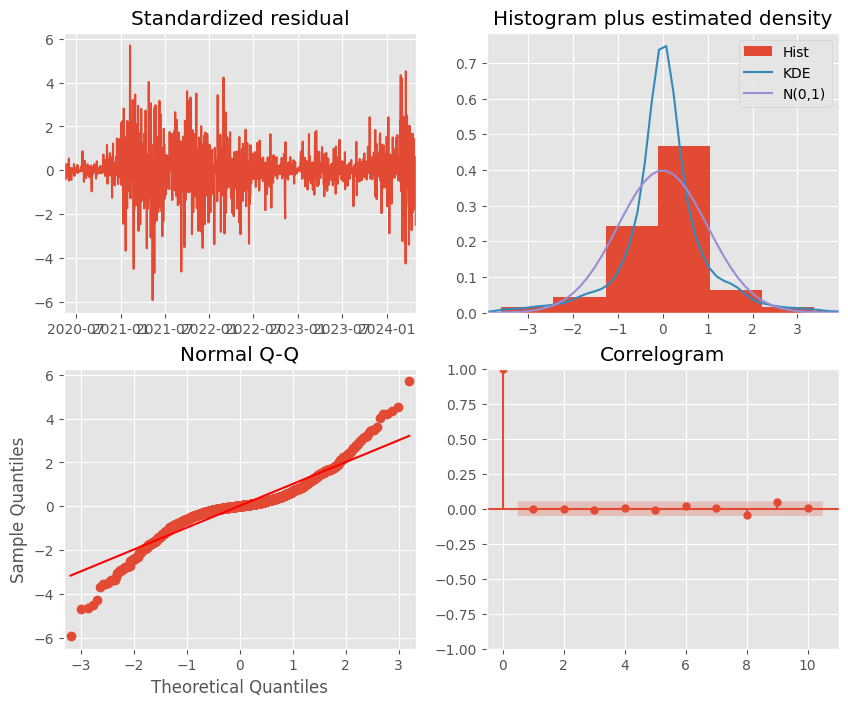

In [76]:
arima_model.plot_diagnostics(figsize=(10, 8))
plt.show()


In [77]:
# Now test ARIMA on test set
try:
    # Predict over the test period using .predict(start, end)
    start = len(y_train_series)
    end = start + len(y_test_series) - 1
    arima_preds_values = arima_model.predict(start=start, end=end)

    arima_preds = pd.Series(arima_preds_values, index=y_test_series.index[:len(arima_preds_values)])

    # Align actual values to prediction index
    y_test_subset = y_test_series.loc[arima_preds.index]

    # Check forecast shape
    print("Test forecast shape:", arima_preds.shape)
    print("Test shape:", y_test_subset.shape)

    # Calculate metrics
    arima_metrics = calculate_metrics(y_test_subset, arima_preds)
    print("\n ARIMA Model Test Metrics:")
    for key, value in arima_metrics.items():
        print(f"{key}: {value:.4f}")

except Exception as e:
    print(f"Error during test prediction or evaluation: {e}")
    traceback.print_exc()

Test forecast shape: (10,)
Test shape: (10,)
Error during test prediction or evaluation: Input contains NaN.


Traceback (most recent call last):
  File "/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_35218/4243520964.py", line 18, in <module>
    arima_metrics = calculate_metrics(y_test_subset, arima_preds)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_35218/1303458955.py", line 20, in calculate_metrics
    mae = mean_absolute_error(y_true_values, y_pred_values)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py", line 277, in mean_absolute_error
    _check_reg_targets_with_floating_dtype(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

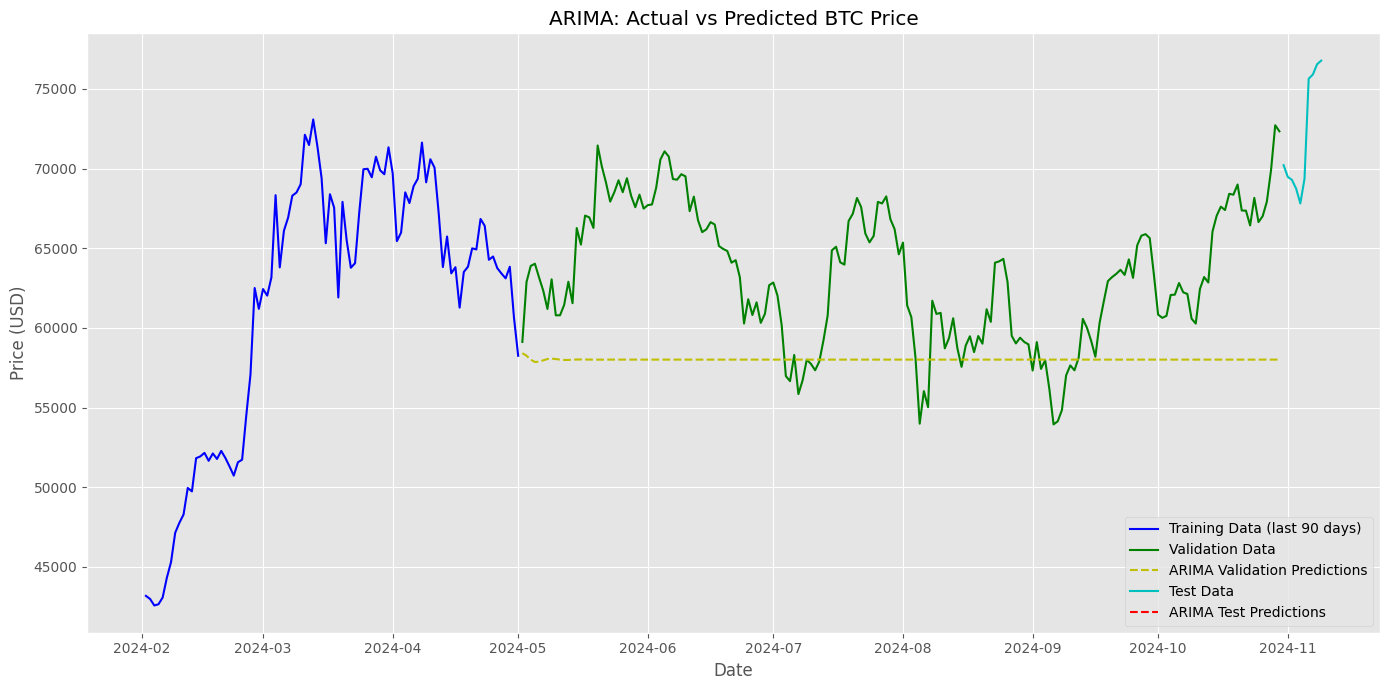

In [78]:
# 📉 Plot ARIMA Forecast vs Actual
try:
    plt.figure(figsize=(14, 7))
    plt.plot(y_train_series.index[-90:], y_train_series[-90:], 'b-', label='Training Data (last 90 days)')
    plt.plot(y_val_subset.index, y_val_subset, 'g-', label='Validation Data')
    plt.plot(arima_val_preds.index, arima_val_preds, 'y--', label='ARIMA Validation Predictions')
    plt.plot(y_test_subset.index, y_test_subset, 'c-', label='Test Data')
    plt.plot(arima_preds.index, arima_preds, 'r--', label='ARIMA Test Predictions')
    plt.title('ARIMA: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Error in plotting:")
    traceback.print_exc()

##### Prophet Model

In [79]:
# Prepare Data for Prophet
print("Preparing data for Prophet...")

try:
    # Ensure datetime format for indices
    y_train_index = pd.to_datetime(y_train.index)
    y_val_index = pd.to_datetime(y_val.index)
    y_test_index = pd.to_datetime(y_test.index)

    # Flatten values
    y_train_values = y_train.values.flatten() if y_train.values.ndim > 1 else y_train.values
    y_val_values = y_val.values.flatten() if y_val.values.ndim > 1 else y_val.values
    y_test_values = y_test.values.flatten() if y_test.values.ndim > 1 else y_test.values

    # Create Prophet-compatible training DataFrame
    prophet_train = pd.DataFrame({
        'ds': y_train_index,
        'y': y_train_values
    })

    display(prophet_train.head())

except Exception as e:
    print("Error in data preparation:")
    traceback.print_exc()


Preparing data for Prophet...


,ds,y
0,2020-05-10,8756.430664
1,2020-05-11,8601.795898
2,2020-05-12,8804.477539
3,2020-05-13,9269.987305
4,2020-05-14,9733.721680


In [80]:
# Fit Prophet Model
print("\nFitting Prophet model...")

try:
    # Instantiate and fit
    prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    prophet_model.fit(prophet_train)

except Exception as e:
    print("Error fitting Prophet model:")
    traceback.print_exc()

12:04:28 - cmdstanpy - INFO - Chain [1] start processing



Fitting Prophet model...


12:04:29 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
# Forecast Using Prophet on Validation Set
try:
    # Create a future DataFrame matching validation dates
    future_val_dates = pd.DataFrame({'ds': y_val_index})
    prophet_val_forecast = prophet_model.predict(future_val_dates)

    # Extract predictions
    prophet_val_preds = pd.Series(
        prophet_val_forecast['yhat'].values, 
        index=pd.to_datetime(prophet_val_forecast['ds']).dt.date
    )

    # Convert validation index to date for comparison
    y_val_date_index = pd.Series(y_val_values, index=pd.to_datetime(y_val.index).date)

    # Find and align on common dates
    val_common_dates = sorted(set(prophet_val_preds.index).intersection(set(y_val_date_index.index)))
    val_aligned_preds = prophet_val_preds.loc[val_common_dates]
    val_aligned_actual = y_val_date_index.loc[val_common_dates]

    # Sanity check
    print(f"Validation Aligned Predictions: {len(val_aligned_preds)}")
    print(f"Validation Aligned Actuals: {len(val_aligned_actual)}")

except Exception as e:
    print("Error during validation forecasting or alignment:")
    traceback.print_exc()

Validation Aligned Predictions: 182
Validation Aligned Actuals: 182


In [82]:
# Evaluate Prophet Model on Validation Set
try:
    prophet_val_metrics = calculate_metrics(val_aligned_actual, val_aligned_preds)
    print("\n📈 Prophet Model Validation Metrics:")
    for key, value in prophet_val_metrics.items():
        print(f"{key}: {value:.4f}")
except Exception as e:
    print("Error calculating validation metrics:")
    traceback.print_exc()


📈 Prophet Model Validation Metrics:
MAE: 4379.7806
RMSE: 5472.6667
MAPE: 6.8289
Directional Accuracy (%): 50.8287
R2: -0.6780


In [84]:
# Forecast Using Prophet on Test Set
try:
    # Create a future DataFrame matching test dates
    future_test_dates = pd.DataFrame({'ds': y_test_index})
    prophet_test_forecast = prophet_model.predict(future_test_dates)

    # Extract predictions
    prophet_test_preds = pd.Series(
        prophet_test_forecast['yhat'].values, 
        index=pd.to_datetime(prophet_test_forecast['ds']).dt.date
    )

    # Convert test index to date for comparison
    y_test_date_index = pd.Series(y_test_values, index=pd.to_datetime(y_test.index).date)

    # Find and align on common dates
    test_common_dates = sorted(set(prophet_test_preds.index).intersection(set(y_test_date_index.index)))
    test_aligned_preds = prophet_test_preds.loc[test_common_dates]
    test_aligned_actual = y_test_date_index.loc[test_common_dates]

    # Sanity check
    print(f"Test Aligned Predictions: {len(test_aligned_preds)}")
    print(f"Test Aligned Actuals: {len(test_aligned_actual)}")

except Exception as e:
    print("Error during test forecasting or alignment:")
    traceback.print_exc()

Test Aligned Predictions: 181
Test Aligned Actuals: 181


In [85]:
# Evaluate Prophet Model on Test Set
try:
    prophet_metrics = calculate_metrics(test_aligned_actual, test_aligned_preds)
    print("\n📈 Prophet Model Test Metrics:")
    for key, value in prophet_metrics.items():
        print(f"{key}: {value:.4f}")
except Exception as e:
    print("Error calculating test metrics:")
    traceback.print_exc()



📈 Prophet Model Test Metrics:
MAE: 16289.1000
RMSE: 18013.9983
MAPE: 17.4338
Directional Accuracy (%): 48.8889
R2: -3.4978


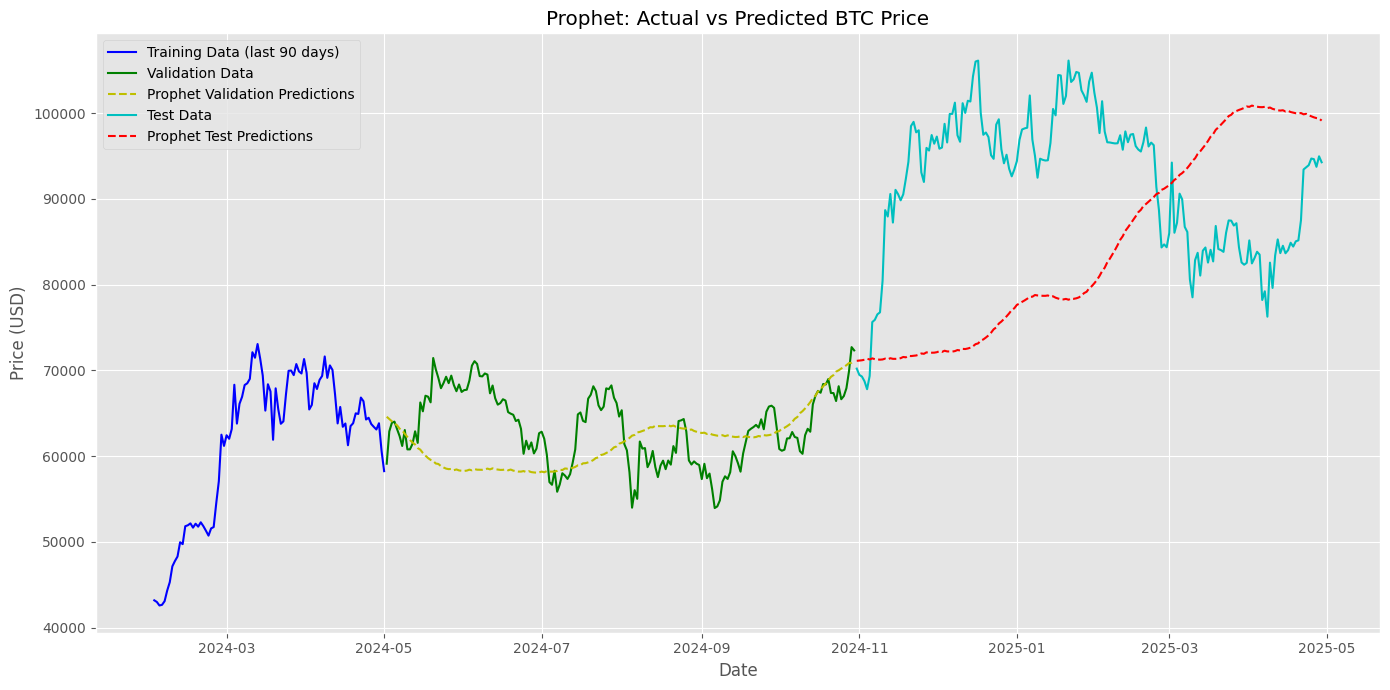

In [86]:
# Plot Prophet Forecast vs Actual
try:
    plt.figure(figsize=(14, 7))
    plt.plot(pd.to_datetime(y_train.index)[-90:], y_train_values[-90:], 'b-', label='Training Data (last 90 days)')
    plt.plot(val_aligned_actual.index, val_aligned_actual, 'g-', label='Validation Data')
    plt.plot(val_aligned_preds.index, val_aligned_preds, 'y--', label='Prophet Validation Predictions')
    plt.plot(test_aligned_actual.index, test_aligned_actual, 'c-', label='Test Data')
    plt.plot(test_aligned_preds.index, test_aligned_preds, 'r--', label='Prophet Test Predictions')

    plt.title('Prophet: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Error in plotting forecast:")
    traceback.print_exc()

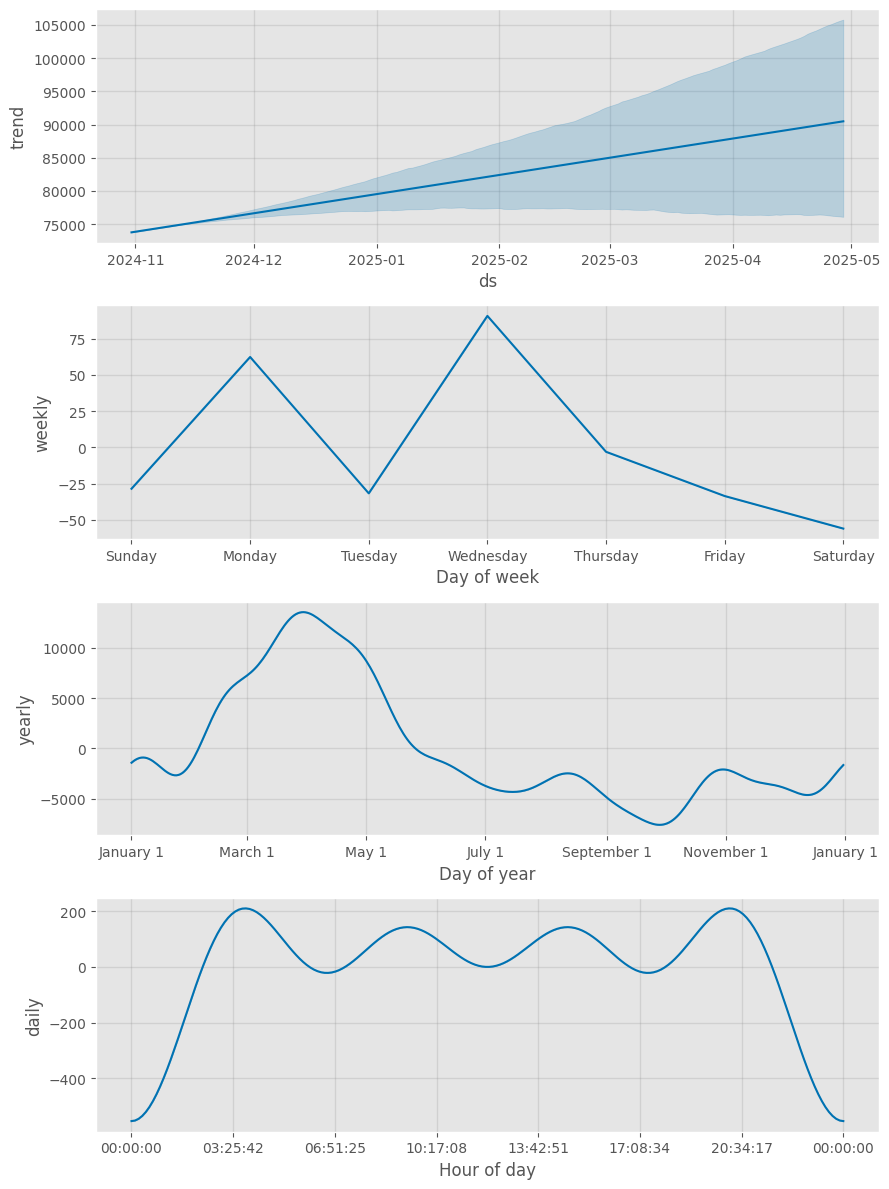

In [87]:
# Plot Prophet Components
try:
    fig = prophet_model.plot_components(prophet_test_forecast)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Error plotting Prophet components:")
    traceback.print_exc()

#### Machine Learning Models

##### Random Forest

In [88]:
# Train a model for feature selection
print("Training a Random Forest model for feature selection")
selector_model = RandomForestRegressor(n_estimators=100, random_state=42)
selector_model.fit(X_train, y_train)
importances = selector_model.feature_importances_

# Create a DataFrame of features and their importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Choose top N features
top_n_features = 10
top_features = feature_importance.head(top_n_features)['Feature'].tolist()

print(f"Selected top {top_n_features} features:")
for i, feature in enumerate(top_features):
    importance = feature_importance.loc[feature_importance['Feature'] == feature, 'Importance'].values[0]
    print(f"{i+1}. {feature}: {importance:.4f}")

Training a Random Forest model for feature selection


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Selected top 10 features:
1. ('BTC_lag_1', ''): 0.9146
2. ('rolling_mean_7d', ''): 0.0630
3. ('BTC_lag_9', ''): 0.0020
4. ('rolling_mean_30d', ''): 0.0017
5. ('BTC_lag_2', ''): 0.0017
6. ('BTC_lag_15', ''): 0.0014
7. ('BTC_lag_6', ''): 0.0013
8. ('BTC_lag_12', ''): 0.0012
9. ('BTC_lag_16', ''): 0.0012
10. ('BTC_lag_14', ''): 0.0009


In [89]:
# Apply selection to all datasets
X_train_selected = X_train[top_features]
X_val_selected = X_val[top_features]
X_test_selected = X_test[top_features]

# Prepare Data for Random Forest
print("Preparing data for Random Forest...")

Preparing data for Random Forest...


In [90]:
try:
    # Convert features to NumPy arrays
    X_train_np = X_train_selected.values
    X_val_np = X_val_selected.values
    X_test_np = X_test_selected.values

    # Flatten target if needed
    y_train_np = y_train.values.flatten() if hasattr(y_train, 'values') and y_train.values.ndim > 1 else np.array(y_train).flatten()
    y_val_np = y_val.values.flatten() if hasattr(y_val, 'values') and y_val.values.ndim > 1 else np.array(y_val).flatten()

    print(f"Debug - X_train shape: {X_train_np.shape}, y_train shape: {y_train_np.shape}")
    print(f"Debug - X_val shape: {X_val_np.shape}, y_val shape: {y_val_np.shape}")
    print(f"Debug - X_test shape: {X_test_np.shape}")

except Exception as e:
    print("Error in data preparation:")
    traceback.print_exc()

Debug - X_train shape: (1453, 10), y_train shape: (1453,)
Debug - X_val shape: (182, 10), y_val shape: (182,)
Debug - X_test shape: (181, 10)


In [91]:
# Feature Scaling
print("Scaling features...")

try:
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_np)
    X_val_scaled = scaler.transform(X_val_np)
    X_test_scaled = scaler.transform(X_test_np)
except Exception as e:
    print(" Error in scaling:")
    traceback.print_exc()

Scaling features...


In [92]:
# Train Random Forest Model
print("Training Random Forest model...")

try:
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train_scaled, y_train_np)
    print("Model training complete.")

except Exception as e:
    print("Error training Random Forest model:")
    traceback.print_exc()



Training Random Forest model...
Model training complete.


In [93]:
# Generate Validation Predictions
print("Making validation predictions...")

try:
    rf_val_preds = rf_model.predict(X_val_scaled)
    print(f"Debug - Validation Predictions shape: {rf_val_preds.shape}")
    
    y_val_np = y_val.values.flatten() if hasattr(y_val, 'values') and y_val.values.ndim > 1 else np.array(y_val).flatten()
    print(f"Debug - y_val shape: {y_val_np.shape}")
    
    # Ensure lengths match
    min_val_len = min(len(rf_val_preds), len(y_val_np))
    rf_val_preds_trimmed = rf_val_preds[:min_val_len]
    y_val_trimmed = y_val_np[:min_val_len]

    val_indices = y_val.index[:min_val_len] if hasattr(y_val, 'index') else np.arange(min_val_len)

    rf_val_preds_series = pd.Series(rf_val_preds_trimmed, index=val_indices)
    y_val_series = pd.Series(y_val_trimmed, index=val_indices)

except Exception as e:
    print("Error generating validation predictions:")
    traceback.print_exc()


Making validation predictions...
Debug - Validation Predictions shape: (182,)
Debug - y_val shape: (182,)


In [94]:
# Evaluate Validation Performance
print("\nEvaluating validation performance...")

try:
    rf_val_metrics = calculate_metrics(y_val_series, rf_val_preds_series)
    print("Random Forest Validation Metrics:")
    for key, value in rf_val_metrics.items():
        print(f"{key}: {value:.4f}")
except Exception as e:
    print("Error calculating validation metrics:")
    traceback.print_exc()


Evaluating validation performance...
Random Forest Validation Metrics:
MAE: 1322.2309
RMSE: 1723.2384
MAPE: 2.0998
Directional Accuracy (%): 53.0387
R2: 0.8336


In [95]:
# Generate Test Predictions
print("Making test predictions...")

try:
    rf_test_preds = rf_model.predict(X_test_scaled)
    print(f"Debug - Test Predictions shape: {rf_test_preds.shape}")
    
    y_test_np = y_test.values.flatten() if hasattr(y_test, 'values') and y_test.values.ndim > 1 else np.array(y_test).flatten()
    print(f"Debug - y_test shape: {y_test_np.shape}")
    
    # Ensure lengths match
    min_test_len = min(len(rf_test_preds), len(y_test_np))
    rf_test_preds_trimmed = rf_test_preds[:min_test_len]
    y_test_trimmed = y_test_np[:min_test_len]

    test_indices = y_test.index[:min_test_len] if hasattr(y_test, 'index') else np.arange(min_test_len)

    rf_test_preds_series = pd.Series(rf_test_preds_trimmed, index=test_indices)
    y_test_series = pd.Series(y_test_trimmed, index=test_indices)

except Exception as e:
    print("Error generating test predictions:")
    traceback.print_exc()

Making test predictions...
Debug - Test Predictions shape: (181,)
Debug - y_test shape: (181,)


In [96]:
# Evaluate Test Performance
print("\nEvaluating test performance...")

try:
    rf_metrics = calculate_metrics(y_test_series, rf_test_preds_series)
    print("Random Forest Test Metrics:")
    for key, value in rf_metrics.items():
        print(f"{key}: {value:.4f}")
except Exception as e:
    print("Error calculating test metrics:")
    traceback.print_exc()



Evaluating test performance...
Random Forest Test Metrics:
MAE: 23640.8951
RMSE: 25133.6265
MAPE: 25.0545
Directional Accuracy (%): 50.5556
R2: -7.7558


Plotting results...


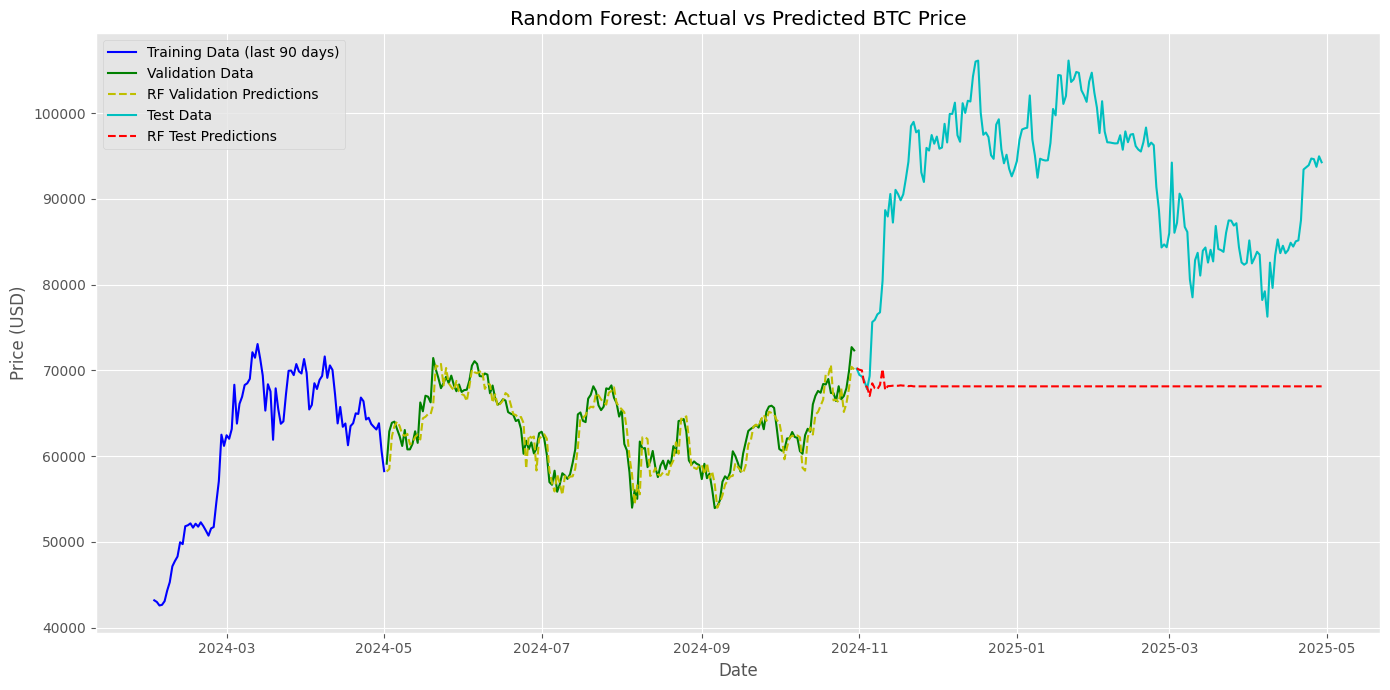

In [97]:
# Plot Actual vs Predicted BTC Prices
print("Plotting results...")

try:
    plt.figure(figsize=(14, 7))
    if hasattr(y_train, 'index'):
        plt.plot(y_train.index[-min(90, len(y_train)):],
                 y_train.values[-min(90, len(y_train)):].flatten(),
                 'b-', label='Training Data (last 90 days)')
    plt.plot(y_val_series.index, y_val_series, 'g-', label='Validation Data')
    plt.plot(rf_val_preds_series.index, rf_val_preds_series, 'y--', label='RF Validation Predictions')
    plt.plot(y_test_series.index, y_test_series, 'c-', label='Test Data')
    plt.plot(rf_test_preds_series.index, rf_test_preds_series, 'r--', label='RF Test Predictions')
    
    plt.title('Random Forest: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Error plotting results:")
    traceback.print_exc()

##### XGBOOST

In [98]:
# Train XGBoost Model
print("\nTraining XGBoost model...")

try:
    # Train XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train)

    # Make validation predictions
    xgb_val_preds = xgb_model.predict(X_val_scaled)
    xgb_val_preds_series = pd.Series(xgb_val_preds, index=y_val.index[:len(xgb_val_preds)])
    
    # Calculate validation metrics
    xgb_val_metrics = calculate_metrics(y_val, xgb_val_preds_series)
    print("\nXGBoost Validation Metrics:")
    for key, value in xgb_val_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Make test predictions
    xgb_test_preds = xgb_model.predict(X_test_scaled)
    xgb_test_preds_series = pd.Series(xgb_test_preds, index=y_test.index[:len(xgb_test_preds)])
    
    # Calculate test metrics
    xgb_metrics = calculate_metrics(y_test, xgb_test_preds_series)
    print("\nXGBoost Test Metrics:")
    for key, value in xgb_metrics.items():
        print(f"{key}: {value:.4f}")

except Exception as e:
    print(f"Error in XGBoost modeling: {e}")
    traceback.print_exc()



Training XGBoost model...

XGBoost Validation Metrics:
MAE: 1460.8299
RMSE: 1876.1869
MAPE: 2.3127
Directional Accuracy (%): 46.4088
R2: 0.8028

XGBoost Test Metrics:
MAE: 24254.4427
RMSE: 25747.2415
MAPE: 25.7165
Directional Accuracy (%): 50.5556
R2: -8.1885


Plotting results...


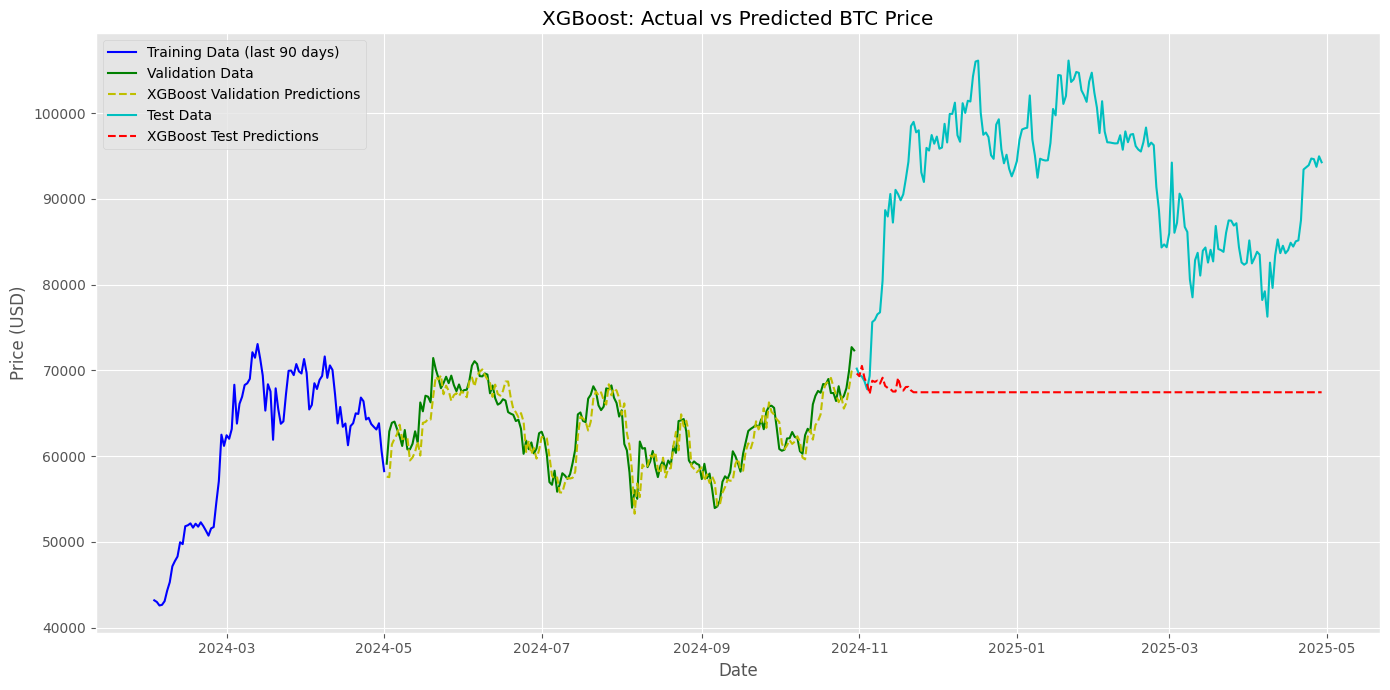

In [99]:
#Plot Actual vs Predicted BTC Prices
print("Plotting results...")

try:
    plt.figure(figsize=(14, 7))
    
    plt.plot(y_train.index[-90:], y_train[-90:], 'b-', label='Training Data (last 90 days)')
    plt.plot(y_val.index[:len(xgb_val_preds)], y_val[:len(xgb_val_preds)], 'g-', label='Validation Data')
    plt.plot(xgb_val_preds_series.index, xgb_val_preds_series, 'y--', label='XGBoost Validation Predictions')
    plt.plot(y_test.index[:len(xgb_test_preds)], y_test[:len(xgb_test_preds)], 'c-', label='Test Data')
    plt.plot(xgb_test_preds_series.index, xgb_test_preds_series, 'r--', label='XGBoost Test Predictions')
    
    plt.title('XGBoost: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Error plotting results:")
    traceback.print_exc()

#### LSTM

In [100]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train_selected)
X_val_scaled = X_scaler.transform(X_val_selected)
X_test_scaled = X_scaler.transform(X_test_selected)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [101]:
# Reshape for LSTM: [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_lstm = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

input_shape = (1, X_train_scaled.shape[1])
print(f"LSTM input shape: {input_shape}")

LSTM input shape: (1, 10)


In [102]:
# Define model
model = Sequential([
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=input_shape),
    LSTM(32, return_sequences=True, dropout=0.2),
    LSTM(16, dropout=0.2),
    Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [103]:
# Train with validation data
history = model.fit(
    X_train_lstm, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_lstm, y_val_scaled),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1857 - val_loss: 0.4756
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0881 - val_loss: 0.0045
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.0069
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0069
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0047
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0043
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0041
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - val_loss: 0.0047
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0066
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - val_loss: 0.0063
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 - val_loss: 0.0061
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

In [104]:
# Predict on validation set
lstm_val_predictions_scaled = model.predict(X_val_lstm)
lstm_val_predictions = y_scaler.inverse_transform(lstm_val_predictions_scaled)

# Evaluate on validation set
lstm_val_metrics = calculate_metrics(y_val, lstm_val_predictions)
print("\nLSTM Model Validation Metrics:")
for key, value in lstm_val_metrics.items():
    print(f"{key}: {value:.4f}")

# Predict on test set
lstm_test_predictions_scaled = model.predict(X_test_lstm)
lstm_test_predictions = y_scaler.inverse_transform(lstm_test_predictions_scaled)

# Evaluate on test set
lstm_metrics = calculate_metrics(y_test, lstm_test_predictions)
print("\nLSTM Model Test Metrics:")
for key, value in lstm_metrics.items():
    print(f"{key}: {value:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

LSTM Model Validation Metrics:
MAE: 2666.4097
RMSE: 3206.2068
MAPE: 4.2345
Directional Accuracy (%): 54.6961
R2: 0.4241
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LSTM Model Test Metrics:
MAE: 11312.3741
RMSE: 12489.5261
MAPE: 11.9421
Directional Accuracy (%): 46.6667
R2: -1.1621


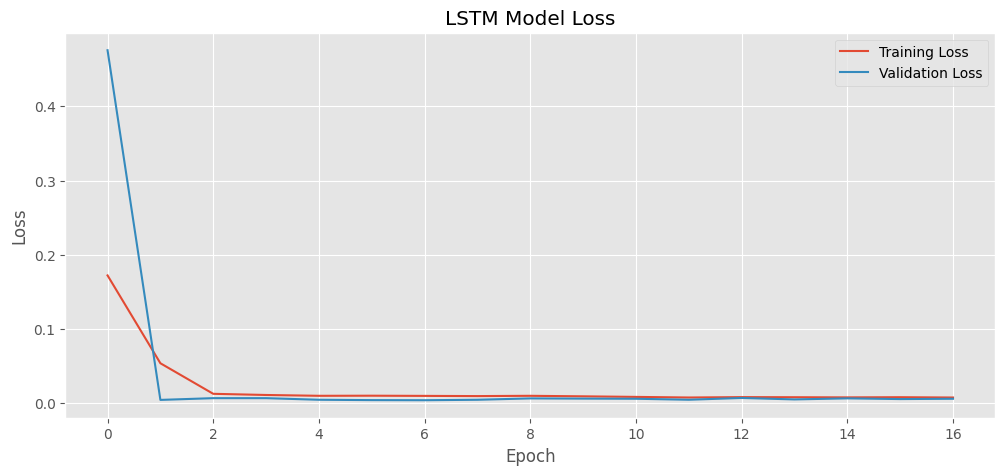

In [105]:
# Loss Plot
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
# Predict
lstm_predictions_scaled = model.predict(X_test_lstm)
lstm_predictions = y_scaler.inverse_transform(lstm_predictions_scaled)

# Evaluate
lstm_metrics = calculate_metrics(y_test, lstm_predictions)
print("\nLSTM Model Metrics with Reduced Features:")
for key, value in lstm_metrics.items():
    print(f"{key}: {value:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

LSTM Model Metrics with Reduced Features:
MAE: 13308.7362
RMSE: 14336.9975
MAPE: 14.1214
Directional Accuracy (%): 45.0000
R2: -1.8491


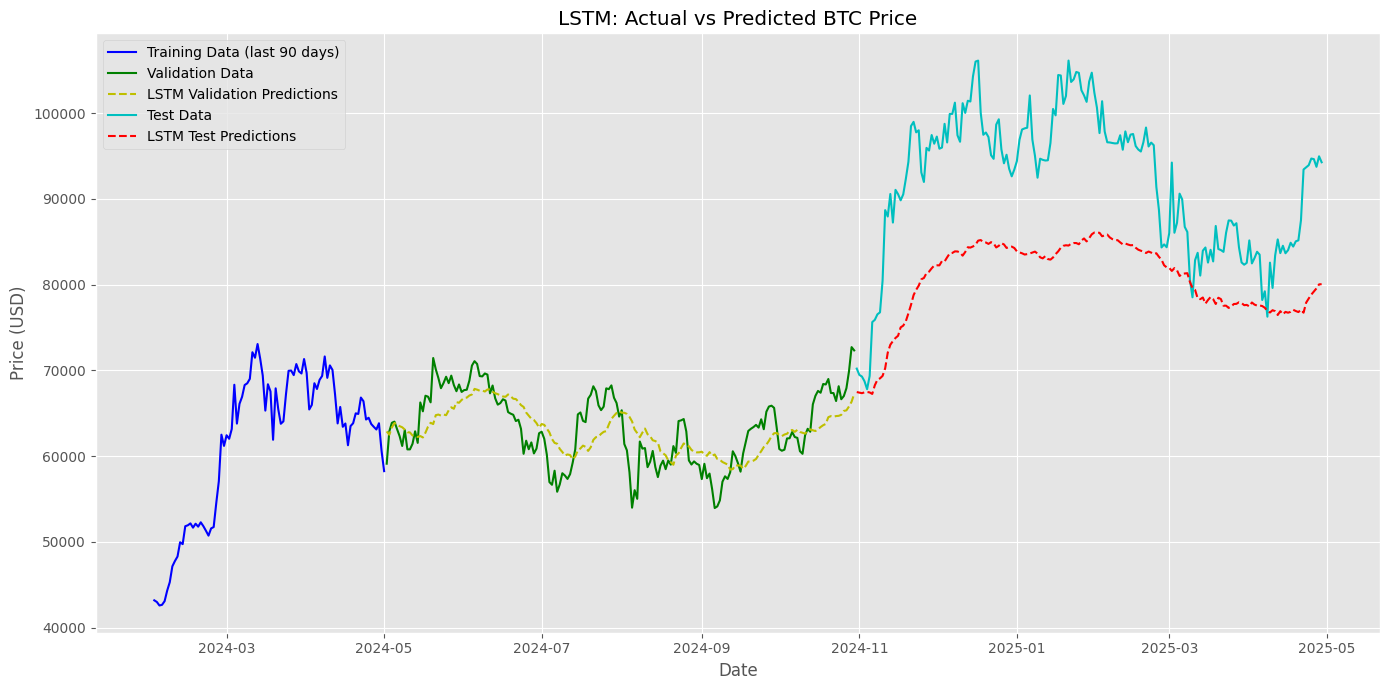

In [106]:
# Prediction Plot
plt.figure(figsize=(14, 7))
plt.plot(y_train.index[-90:], y_train[-90:], 'b-', label='Training Data (last 90 days)')
plt.plot(y_val.index, y_val, 'g-', label='Validation Data')
plt.plot(y_val.index, lstm_val_predictions, 'y--', label='LSTM Validation Predictions')
plt.plot(y_test.index, y_test, 'c-', label='Test Data')
plt.plot(y_test.index, lstm_test_predictions, 'r--', label='LSTM Test Predictions')
plt.title('LSTM: Actual vs Predicted BTC Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Conclusion

In [ ]:
# Collect all metrics into a DataFrame for comparison
model_names = ['ARIMA', 'Prophet', 'Random Forest', 'XGBoost', 'LSTM']
all_test_metrics = [arima_metrics, prophet_metrics, rf_metrics, xgb_metrics, lstm_metrics]
all_val_metrics = [arima_val_metrics, prophet_val_metrics, rf_val_metrics, xgb_val_metrics, lstm_val_metrics]

# Create DataFrames with all metrics
test_metrics_df = pd.DataFrame(all_test_metrics, index=model_names)
val_metrics_df = pd.DataFrame(all_val_metrics, index=model_names)

# Display the comparison
print("Validation Performance Comparison:")
display(val_metrics

In [107]:
# Collect all metrics into a DataFrame for comparison
model_names = ['ARIMA', 'Prophet', 'Random Forest', 'XGBoost', 'LSTM']
all_metrics = [arima_metrics, prophet_metrics, rf_metrics, xgb_metrics, lstm_metrics]

# Create a DataFrame with all metrics
metrics_df = pd.DataFrame(all_metrics, index=model_names)

# Display the comparison
print("Model Comparison:")
display(metrics_df)

# Create bar plots to visualize performance
plt.figure(figsize=(16, 12))

# Plot for each metric
metrics = ['MAE', 'RMSE', 'MAPE', 'Directional Accuracy (%)', 'R2']
for i, metric in enumerate(metrics):
    plt.subplot(3, 2, i+1)
    sns.barplot(x=metrics_df.index, y=metrics_df[metric])
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.tight_layout()
plt.show()

# Final recommendations
print("\n\nFinal Recommendations:")
print("======================")

# Determine best models based on MAE
best_short_term = metrics_df.iloc[:5]['MAE'].idxmin()
best_long_term = metrics_df.iloc[:5]['RMSE'].idxmin()
best_directional = metrics_df.iloc[:5]['Directional Accuracy (%)'].idxmax()

print(f"Best model for short-term (1-day ahead) forecasting: {best_short_term}")
print(f"Best model for accuracy (based on RMSE): {best_long_term}")
print(f"Best model for directional accuracy: {best_directional}")

print("\nRecommendations:")
print("1. For daily trading decisions, use the", best_directional, "model as it best predicts price direction.")
print("2. For price targets, use the", best_short_term, "model for the most accurate price predictions.")
print("3. For longer-term forecasting (7-30 days), the results suggest using", 
      "multi-step forecasting with XGBoost or Prophet may be most reliable.")

print("\nLimitations and Considerations:")
print("- Cryptocurrency markets are highly volatile and influenced by external factors not captured in our models.")
print("- Past performance doesn't guarantee future results, especially in crypto markets.")
print("- Models should be regularly retrained as new data becomes available.")

NameError: name 'arima_metrics' is not defined